# Epigenomics Assignment (TF ChIP-Sequencing)
## Kodai Tsurumi
### Master of Bioinformatics, KU Leuven
#### Dec 2024

### Title
**TF ChIP-Seq Analysis of THAP1 in Homo sapiens**
### Organism
*Homo sapiens*
### Summary
This notebook details the ChIP-seq analysis of THAP1 that is revealed in the paper as a transcription factor implicated in the regulation of SNCA (alpha-synuclein), a critical protein associated with Parkinson’s disease (PD). The analysis aims to explore THAP1's role in transcriptional regulation and its potential impact on PD-related molecular pathways.

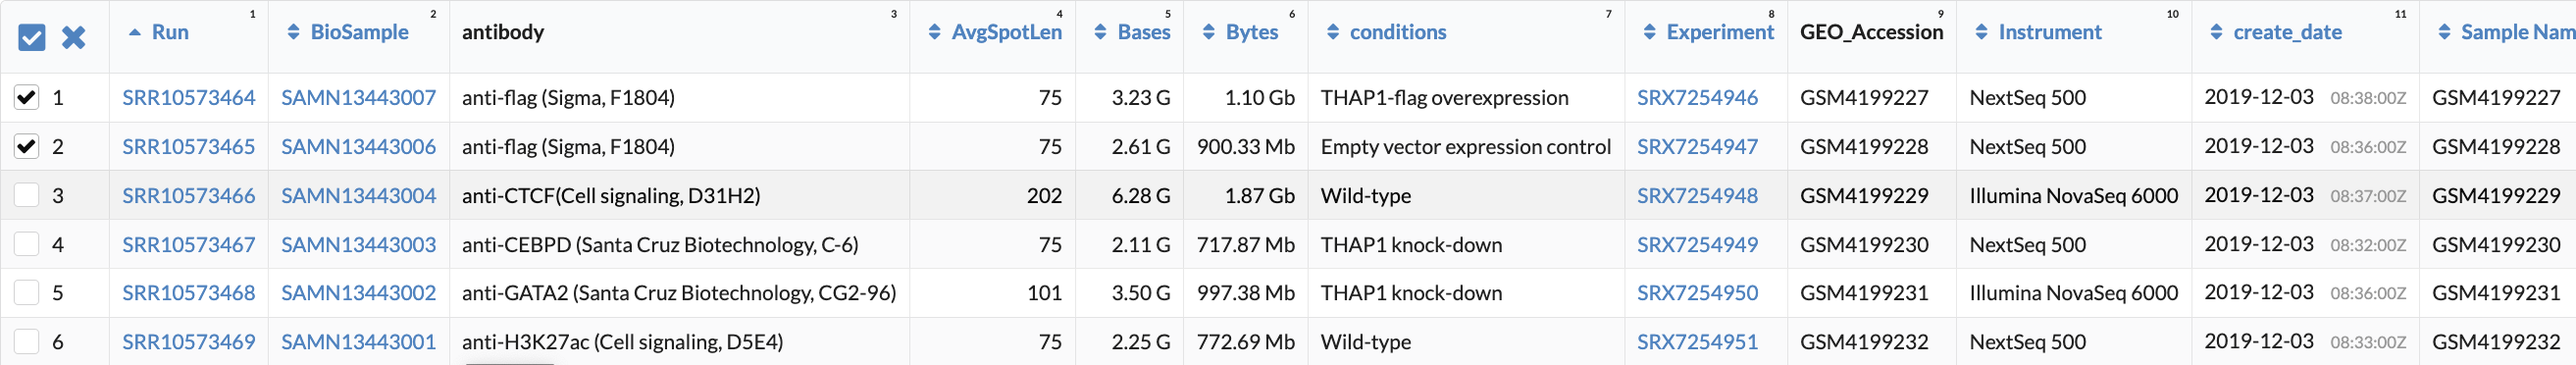
### Reference
(**GEO accession: GSE141244**)\
Study paper:
Cheng F, Zheng W, Barbuti PA, et al. DYT6 mutated THAP1 is a cell type-dependent regulator of the SP1 family. Brain. 2022;145(11):3968-3984. doi: 10.1093/brain/awac001. PMID: 35015830.

## 0. Set up directly

In [1]:
pwd

/mnt/storage/r0965964/jupyternotebooks/epigenetics_assignment


In [1]:
mkdir -p /mnt/storage/$USER/jupyternotebooks/epigenomics_assignment
cd /mnt/storage/$USER/jupyternotebooks/epigenomics_assignment

## 1. Get reads

The cortical interneurons (cINs) were treated with anti-H3K4me1, which is an antibody for mono-methylation of the 4th lysine residue of histone H3.

**FASTQ files:**  
**SRR16609725 --> control cells treated with anti-H3K4me1  
SRR16609727 --> schizophrenia cells treated with anti-H3K4me1**

In [3]:
vdb-config -s /repository/user/cache-disabled=true

**Download all reads:**

In [6]:
# Test fastq-dumnp download
fastq-dump -X 5 -Z SRR10573464

Read 5 spots for SRR10573464
Written 5 spots for SRR10573464
@SRR10573464.1 1 length=75
GTCTCTTGTCACCNAGCTAAAACCCAAAAGGTCCCTTTTTGGAGAATGGGATTTATTATTACCATAATANAGTGA
+SRR10573464.1 1 length=75
A6AAAEEEEEEEE#AEEEEEEEEEAEEE/EAEEAEEEEEEEEEEAEEEAEEAEEEEEEEEEEAEEEEEE#EEE/A
@SRR10573464.2 2 length=75
ATATAGACATATTNATAGGGTCTGGATTTTCAAAGGGACCTAAAAACTTATGTACTACCAACTACAGAANGTAAA
+SRR10573464.2 2 length=75
AAAAAEEEAEEEA#EEEE66EAEEAEEE/EEAEEE/EEEEEEEEEEEE/EEAAEE/EE<</E/EA</EE#E/<EE
@SRR10573464.3 3 length=75
CATCCCTGAATCCNATCCATGAGCCGGCTCCTGAGCAGGGGCCAAGGGCTCAGCTTGTGCTGGGGCTACNGCTTC
+SRR10573464.3 3 length=75
AAAAAEEEEEEEE#EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE#AEEEE
@SRR10573464.4 4 length=75
TGTGTGTATCTTTTGTCTTACTCTCCTTCTCTGCCTGTCCGTCTGTCTGTCTGTCTCTCTCTCTCCCTGNCCCTC
+SRR10573464.4 4 length=75
AAAAAEEEEEEEEEEEEEE6EE/EEEEEEEEEEAAEEEE6EEEEEEEEEEEEEEAEAEAE/EEE</EEE#/AAE6
@SRR10573464.5 5 length=75
TCATTAGAAGTGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCTAGACAGGTGGATCACAGGGTCAGGAG
+SRR10573464

In [7]:
# Download THAP1 fastq file: SRR10573464
fastq-dump SRR10573464 --verbose \
        -O /mnt/storage/$USER/jupyternotebooks/epigenomics_assignment

Preference setting is: Prefer SRA Normalized Format files with full base quality scores if available.
SRR10573464 is an SRA Normalized Format file with full base quality scores.
Read 43023044 spots for SRR10573464
Written 43023044 spots for SRR10573464


In [30]:
# Download Control fastq file: SRR10573465
fastq-dump SRR10573465 --verbose \
        -O /mnt/storage/$USER/jupyternotebooks/epigenomics_assignment

Preference setting is: Prefer SRA Normalized Format files with full base quality scores if available.
SRR10573465 is an SRA Normalized Format file with full base quality scores.
Read 34754260 spots for SRR10573465
Written 34754260 spots for SRR10573465


In [12]:
# rename to the target TF name for ease 
mv SRR10573464.fastq THAP1.fastq

In [32]:
mv SRR10573465.fastq Control.fastq

## 2. QC
**Check read quality:**

In [42]:
# FastQC check
mkdir -p QC_results
fastqc *.fastq -o QC_results

Started analysis of Control.fastq
Approx 5% complete for Control.fastq
Approx 10% complete for Control.fastq
Approx 15% complete for Control.fastq
Approx 20% complete for Control.fastq
Approx 25% complete for Control.fastq
Approx 30% complete for Control.fastq
Approx 35% complete for Control.fastq
Approx 40% complete for Control.fastq
Approx 45% complete for Control.fastq
Approx 50% complete for Control.fastq
Approx 55% complete for Control.fastq
Approx 60% complete for Control.fastq
Approx 65% complete for Control.fastq
Approx 70% complete for Control.fastq
Approx 75% complete for Control.fastq
Approx 80% complete for Control.fastq
Approx 85% complete for Control.fastq
Approx 90% complete for Control.fastq
Approx 95% complete for Control.fastq
Analysis complete for Control.fastq
Started analysis of THAP1.fastq
Approx 5% complete for THAP1.fastq
Approx 10% complete for THAP1.fastq
Approx 15% complete for THAP1.fastq
Approx 20% complete for THAP1.fastq
Approx 25% complete for THAP1.fast

In [18]:
ls

Epigenetics_ChIP_seq.ipynb  THAP1.fastq  THAP1_fastqc.html  THAP1_fastqc.zip


In [15]:
# Count reads
wc -l THAP1.fastq | awk '{ print $1/4 }'

43023044


`fastqc_report.html` result here
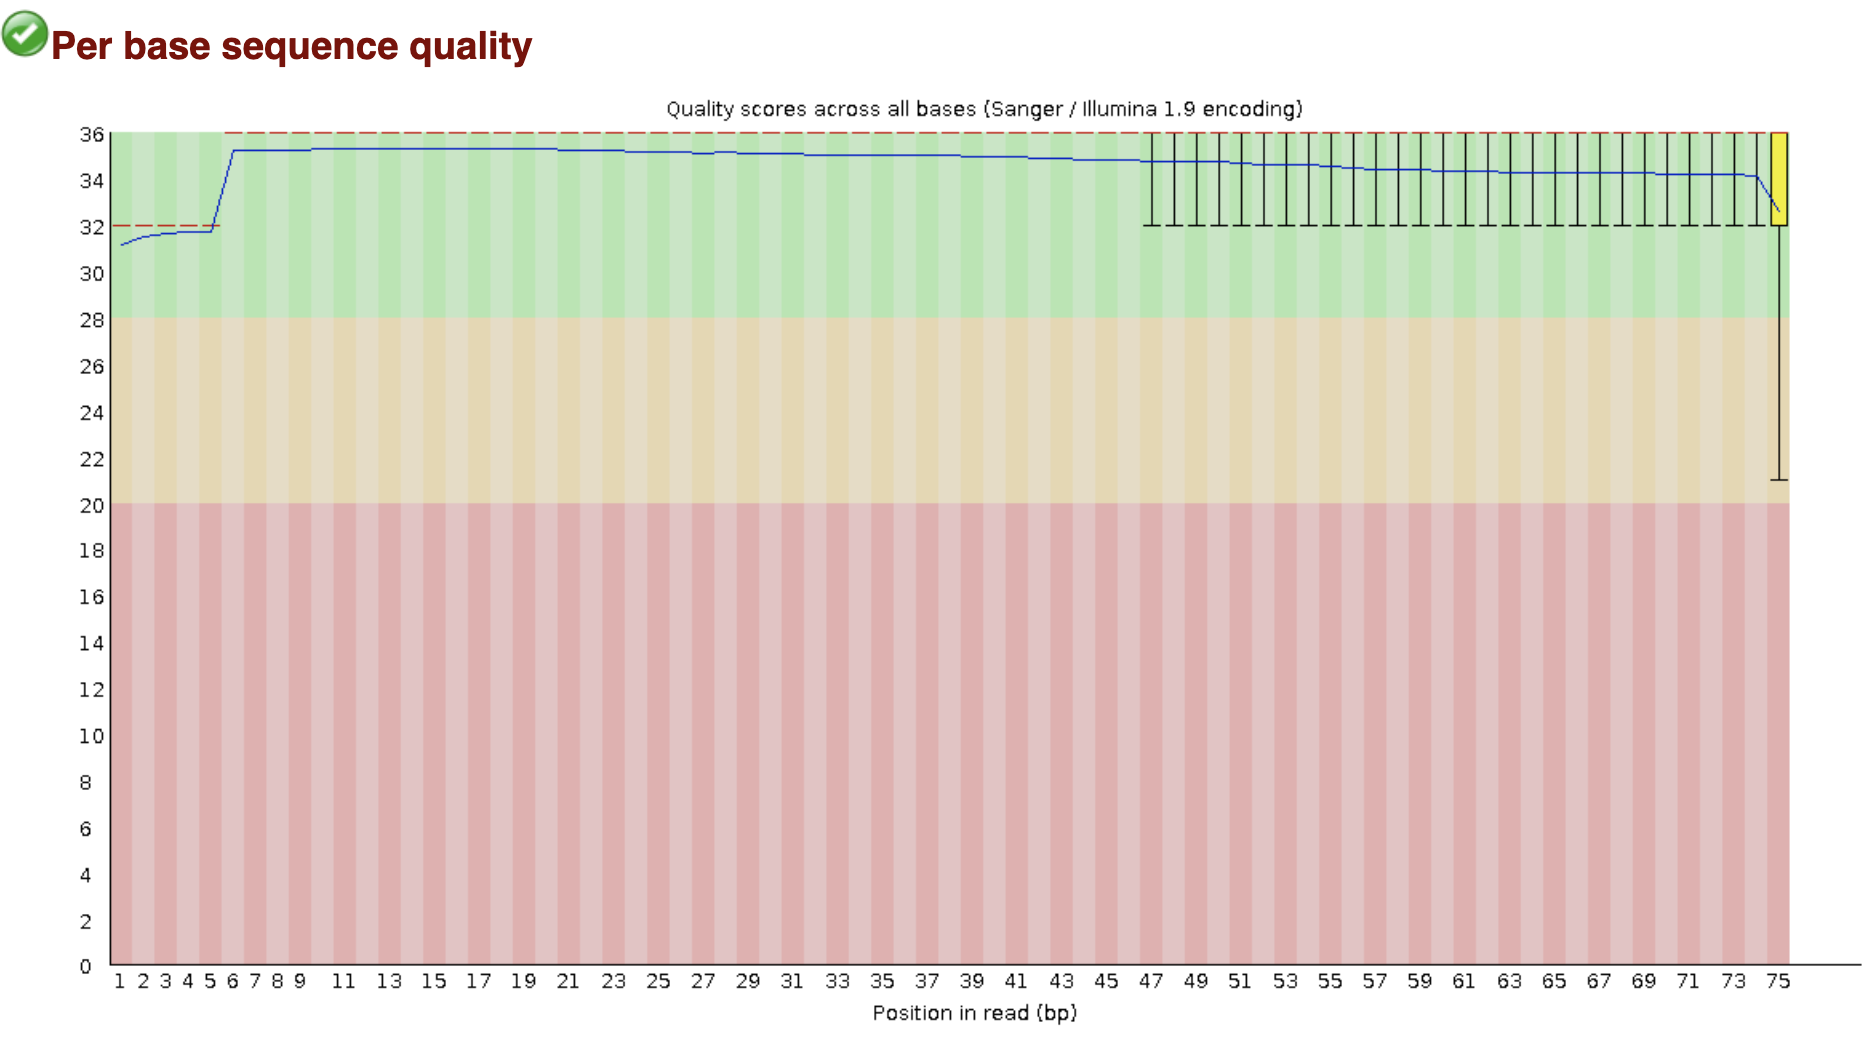

## 3. Alignment
Align the fastq file to hg19 genome reference using bowtie2

In [66]:
bowtie2

No index, query, or output file specified!
Bowtie 2 version 2.3.4.1 by Ben Langmead (langmea@cs.jhu.edu, www.cs.jhu.edu/~langmea)
Usage: 
  bowtie2 [options]* -x <bt2-idx> {-1 <m1> -2 <m2> | -U <r> | --interleaved <i>} [-S <sam>]

  <bt2-idx>  Index filename prefix (minus trailing .X.bt2).
             NOTE: Bowtie 1 and Bowtie 2 indexes are not compatible.
  <m1>       Files with #1 mates, paired with files in <m2>.
             Could be gzip'ed (extension: .gz) or bzip2'ed (extension: .bz2).
  <m2>       Files with #2 mates, paired with files in <m1>.
             Could be gzip'ed (extension: .gz) or bzip2'ed (extension: .bz2).
  <r>        Files with unpaired reads.
             Could be gzip'ed (extension: .gz) or bzip2'ed (extension: .bz2).
  <i>        Files with interleaved paired-end FASTQ reads
             Could be gzip'ed (extension: .gz) or bzip2'ed (extension: .bz2).
  <sam>      File for SAM output (default: stdout)

  <m1>, <m2>, <r> can be comma-separated lists (no whit

: 1

In [20]:
bowtie2 -x /mnt/storage/data/resources/bowtie2/hg19 THAP1.fastq -S THAP1.sam

43023044 reads; of these:
  43023044 (100.00%) were unpaired; of these:
    1097932 (2.55%) aligned 0 times
    30848786 (71.70%) aligned exactly 1 time
    11076326 (25.75%) aligned >1 times
97.45% overall alignment rate


In [1]:
ls /mnt/storage/db/star

ce11  dm3  hg19  hg38  mm10


In [23]:
head -500 *.sam | tail -5

SRR10573464.410	16	chr1	47945503	42	75M	*	0	0	AAAATGCCAGGATAGGGTGAGCTGGTGTCCAAGCCTGTGAACCTTCACCACCCCTCACCTCTTGGCCTCTCCATC	EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAAAAA	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:75	YT:Z:UU
SRR10573464.411	0	chr2	84872743	38	75M	*	0	0	GTAAATTTGTTTAAGTTCCTTATAGATGCTGGATATTAGACCTTTGCCAAATGCATAGATTGCAAAAATATTCAC	AAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE	AS:i:0	XS:i:-38	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:75	YT:Z:UU
SRR10573464.412	16	chr8	146273487	42	75M	*	0	0	AAAGGCCCGTGAATGCAATCAATGTGGAAAGCCTTCAATTGGAGCTCAGCACTTGCTAAAAATCAGATAATTAAC	EEEEEEEEEEAEEEEEEEAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAAAAA	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:75	YT:Z:UU
SRR10573464.413	16	chr5	140701211	42	75M	*	0	0	TGGGGAAACAAGGGTGATTCCTTTTTATGTGCTTGATTTAGATGTAAATGTAAACAGAGAAGGAAGTGTTCTTTT	AA/E/AE/EEEE/6EEEEEEEEEEEEEAEEE/EEEEEEEAEEAEEEEEEEEEAEAEEEEEEAE/AAEE/AAAAAA	AS:i:0	XN:i:0	XM:i:0	XO:

Change SAM file to BAM file

In [21]:
samtools view -S -b THAP1.sam > THAP1.bam

We can delete the SAM file now to save space

In [24]:
rm THAP1.sam

How many reads are in the BAM file?


In [25]:
samtools view -c THAP1.bam

43023044


In [26]:
# Number of mapped reads.
samtools view -c -F 260 THAP1.bam

41925112


Now we are going to create the .bai index so we can use the BAM file in IGV

In [27]:
samtools sort -O bam -o THAP1.sorted.bam THAP1.bam

[bam_sort_core] merging from 13 files and 1 in-memory blocks...


In [28]:
samtools index THAP1.sorted.bam

### Visualize THAP1 with IGV viewer
Showing SNCA gene region which is THAP1's target gene

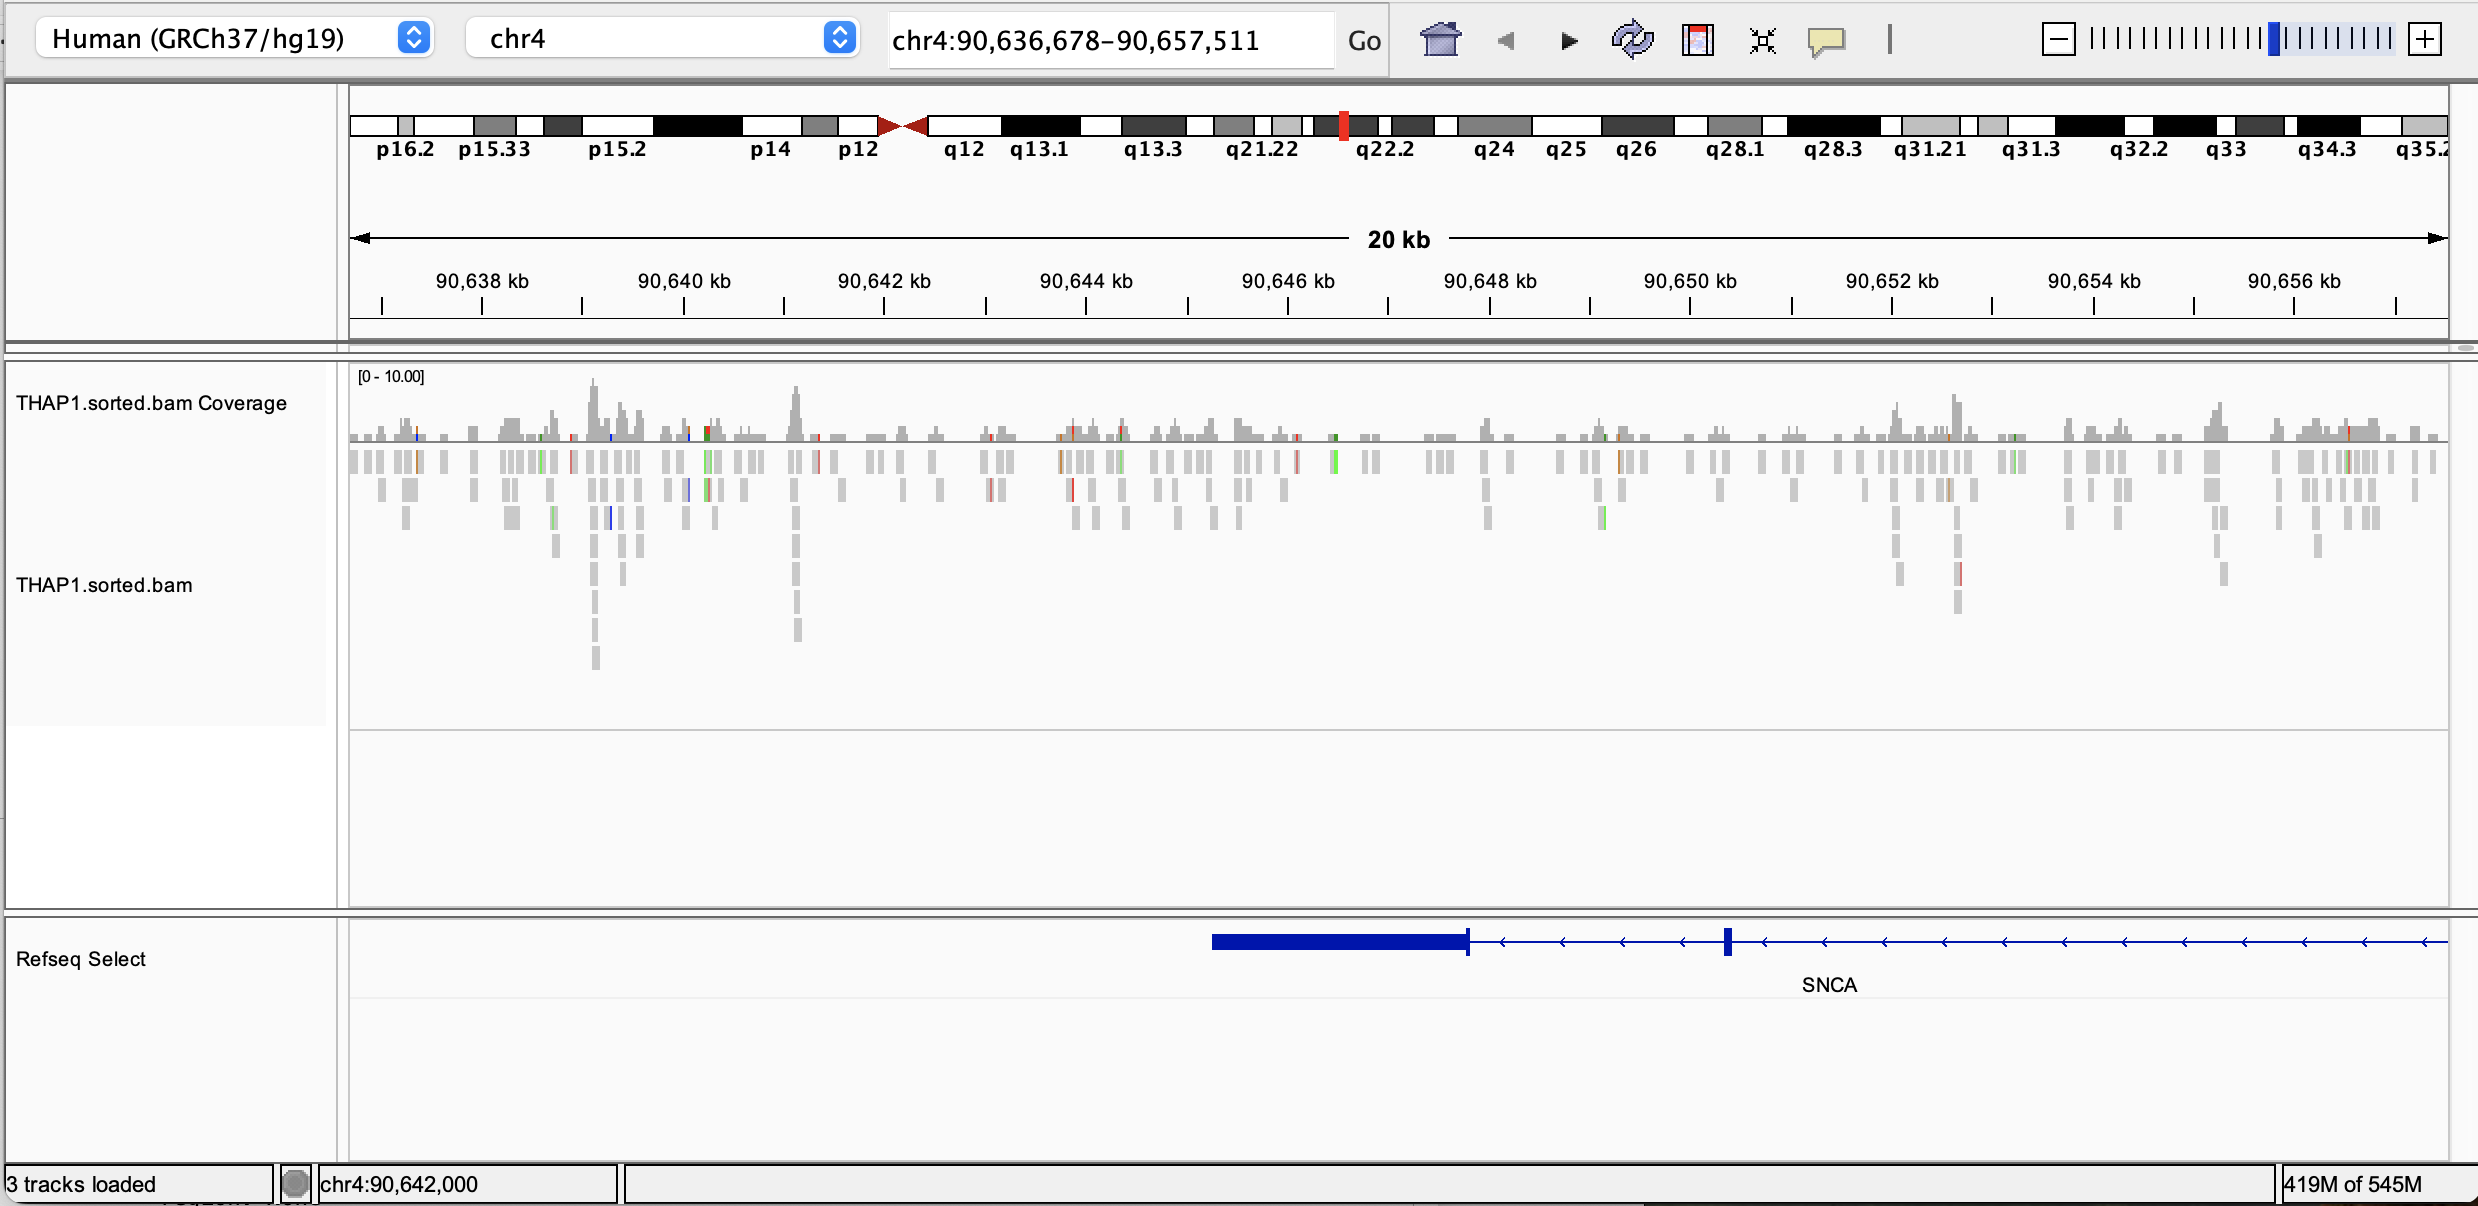

## Alignment of the control data ("input")
Control: ChIP_input_MCF7-chr19.fastq (Empty vector expression control)

In [33]:
bowtie2 -x /mnt/storage/data/resources/bowtie2/hg19 \
        Control.fastq -S Control.sam

34754260 reads; of these:
  34754260 (100.00%) were unpaired; of these:
    853562 (2.46%) aligned 0 times
    24318441 (69.97%) aligned exactly 1 time
    9582257 (27.57%) aligned >1 times
97.54% overall alignment rate


In [34]:
samtools view -S -b Control.sam > Control.bam

Delete the SAM file again

In [35]:
rm Control.sam

Count reads

In [36]:
samtools view -c Control.bam

34754260


Sort and index

In [37]:
samtools sort -O bam -o Control.sorted.bam Control.bam

[bam_sort_core] merging from 10 files and 1 in-memory blocks...


In [38]:
# Index BAM and change into .bam.bai
samtools index Control.sorted.bam

Generate a bigwig file that contains only the coverage of the reads, not the individual reads (binary)
* use the .bw file if the purpose is explanatory visualization avoiding downloading large bam file

### Visualize THAP1 with Control

**The IGV visualisation of THAP1 vs Control around the beggining of SNCA gene (.bam and .bai file)** \
The upper track shows Control and the lower track THAP1.

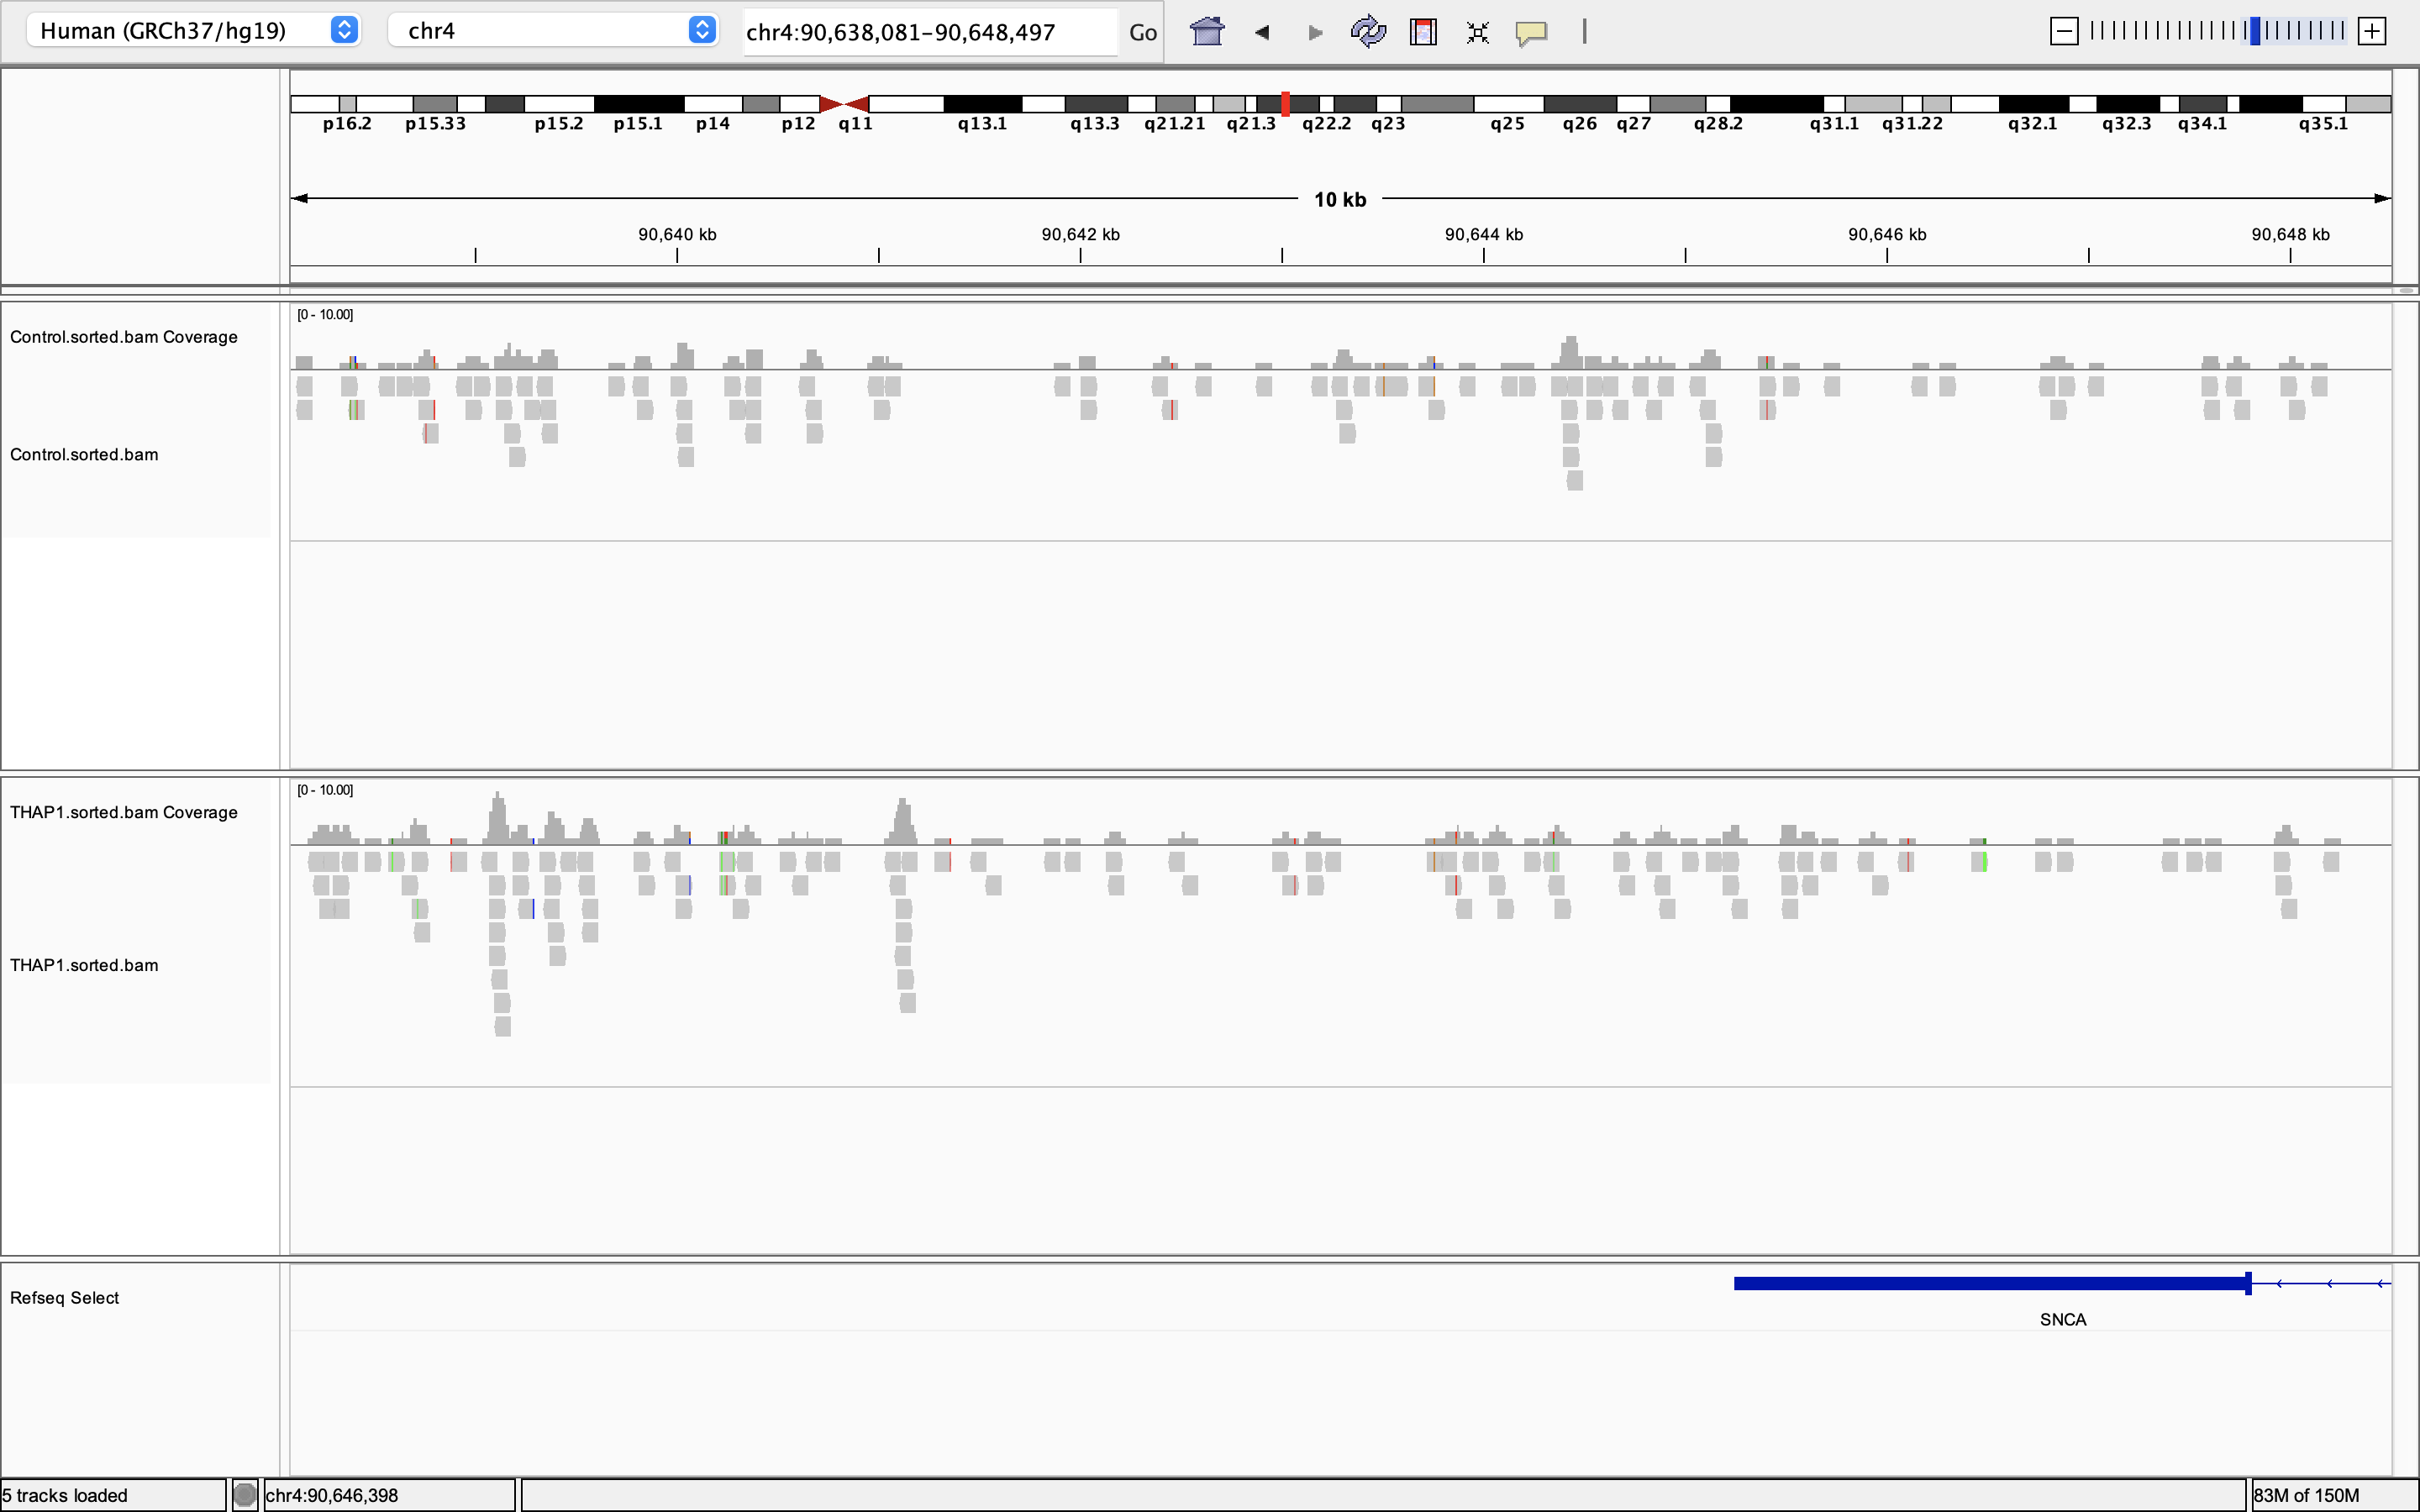

**Comparison of BAM files with BigWig files (obtained from GEO)**

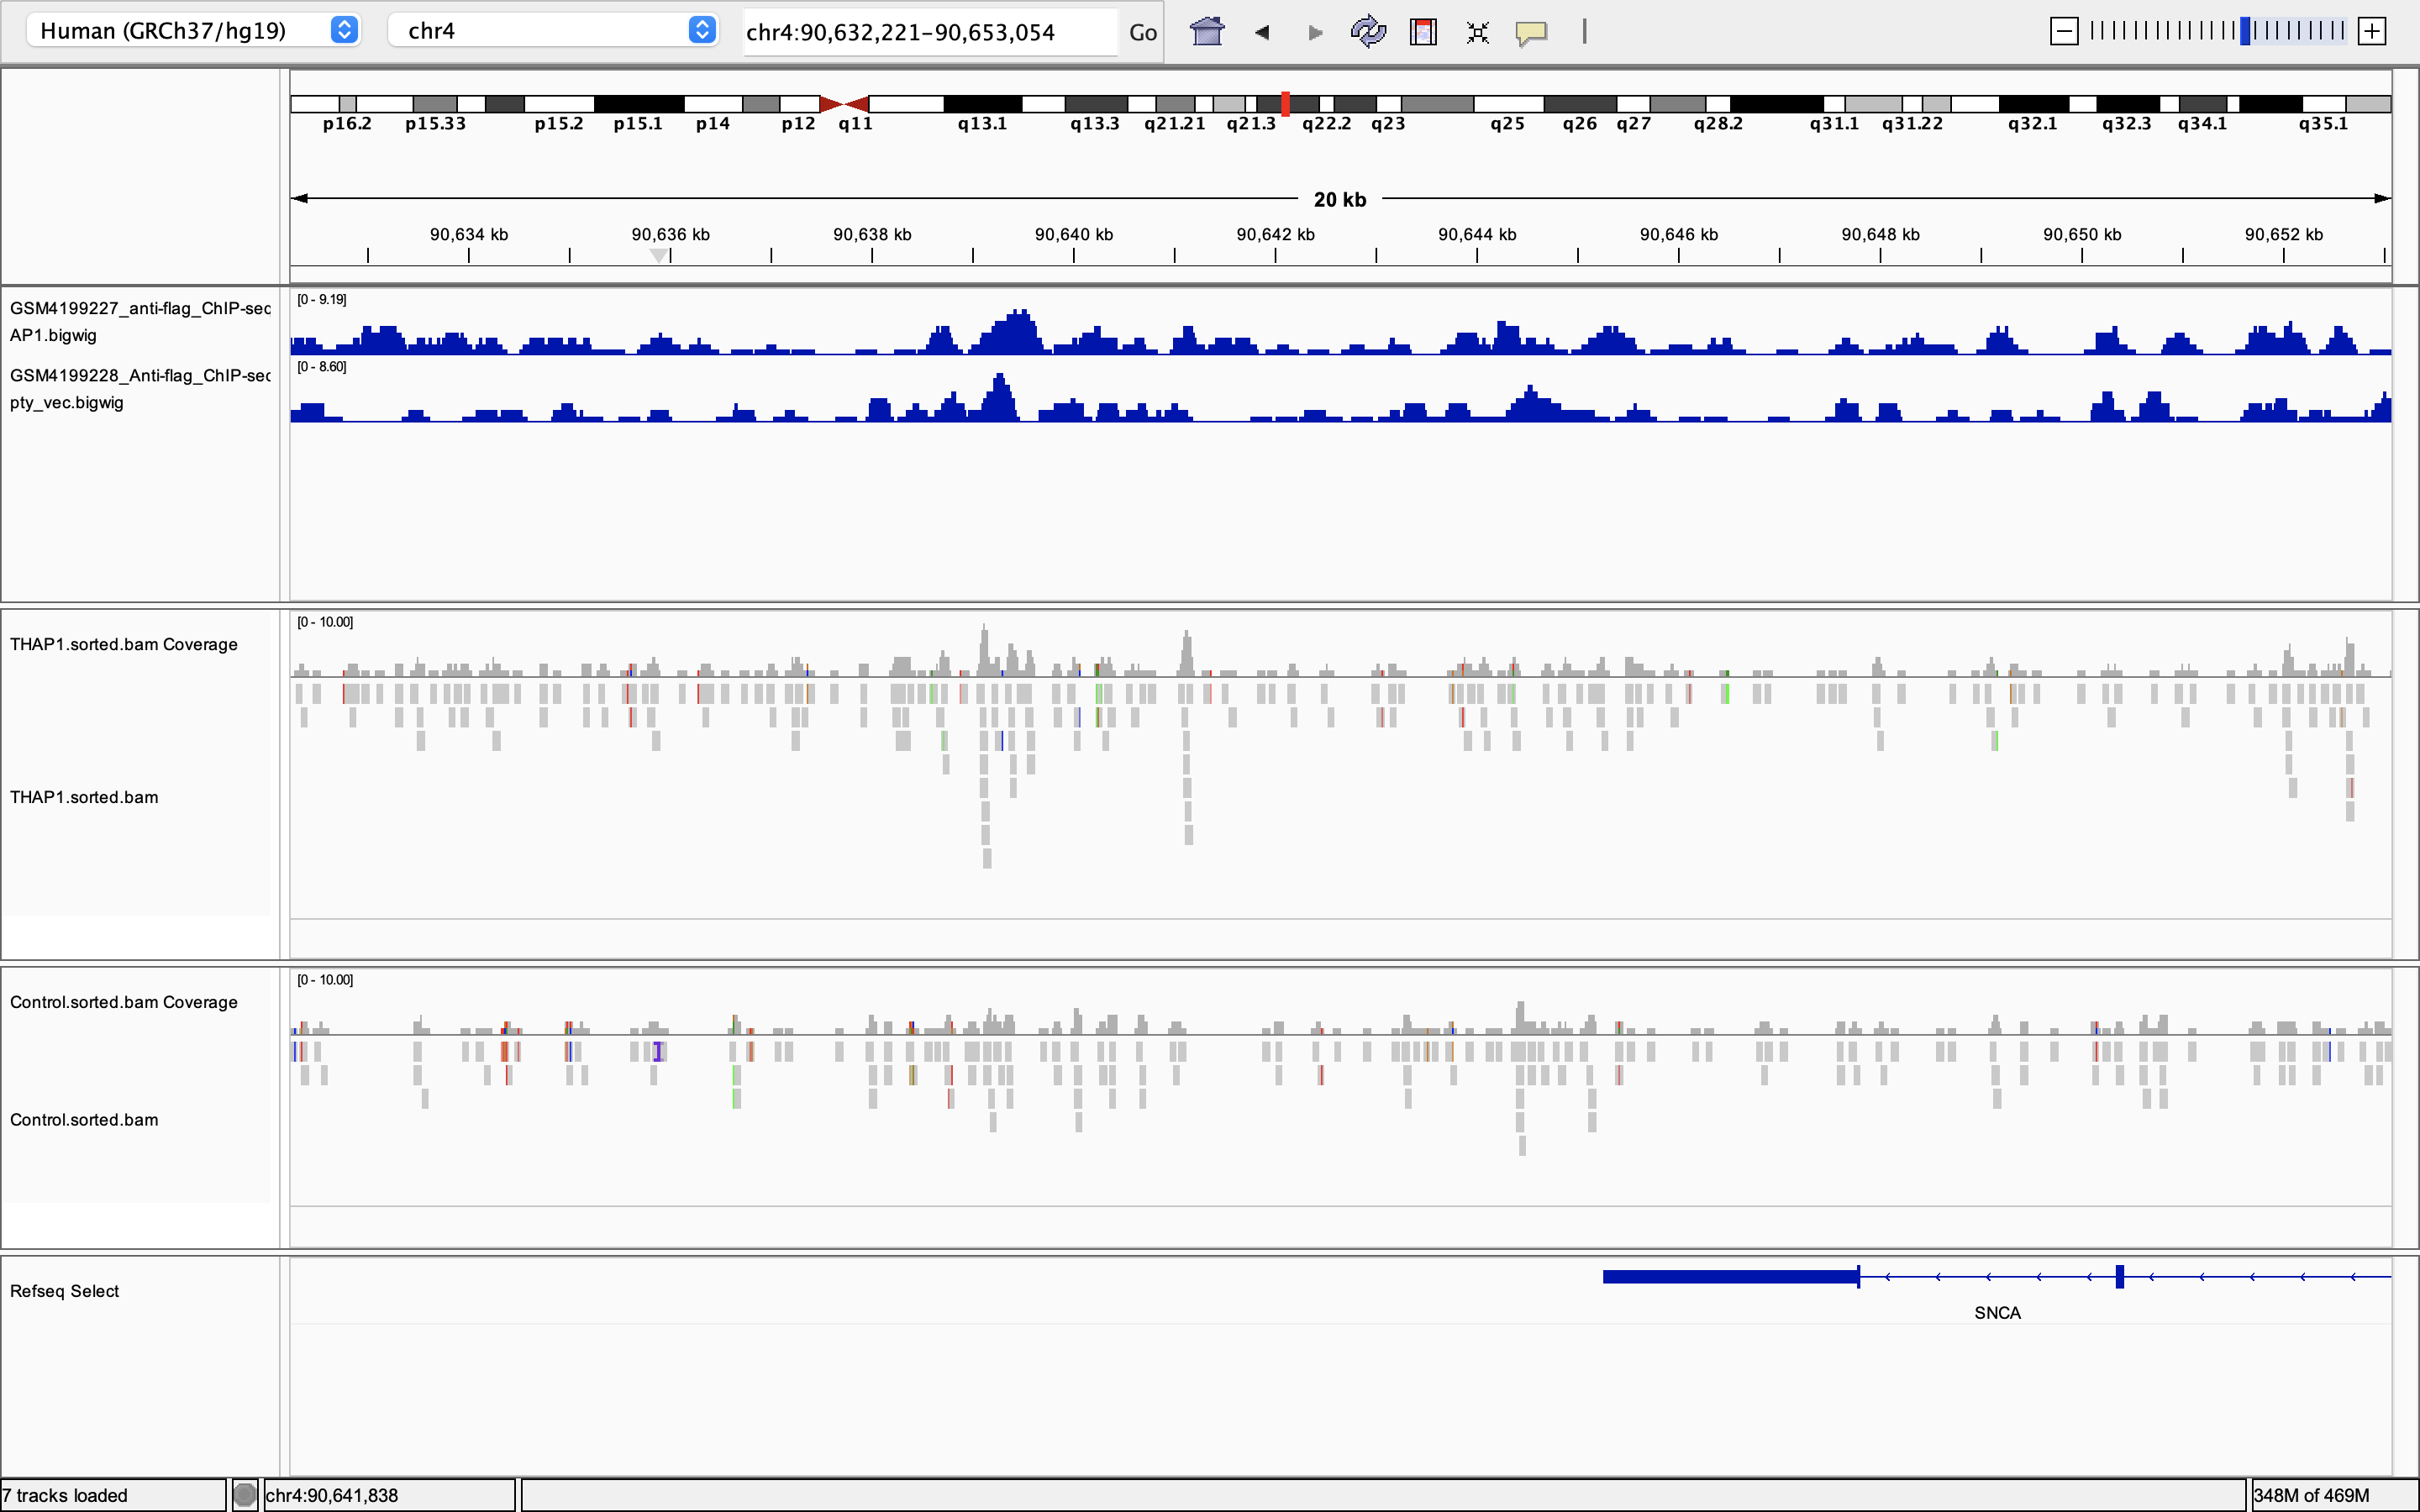


The paper revealed that the ernrichement of the upstream of SNCA gene near Transcription starting site (TSS).\
However, the visual inspection of read enrichment using IGV does not reveal a clear difference between the experimental and control samples.

## 4. Peak calling with MACS2

Generate a bigwig file that contains only the coverage of the reads, not the individual reads. \
Use bamCoverage tool from the package deeptools to create a bigWig file from the BAM file for visualization \
The effective genome size of GRCh37: **2,864,785,220**
(https://deeptools.readthedocs.io/en/develop/content/feature/effectiveGenomeSize.html)

In [14]:
# Create bigWig file (Small bin size) 
bamCoverage -b THAP1.sorted.bam \
            --normalizeUsing RPGC \
            --effectiveGenomeSize 2864785220 \
            --outFileName THAP1-full.bw \
            -bs 5 

normalization: 1x (effective genome size 2864785220)
bamFilesList: ['THAP1.sorted.bam']
binLength: 5
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: read length
numberOfProcessors: 1
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 5
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000


### Genome-wide ChIP-seq peaks

In [3]:
macs2 callpeak -t THAP1.bam -c Control.bam -n THAP1-full -g hs -q 0.05

INFO  @ Sun, 22 Dec 2024 23:51:04: 
# Command line: callpeak -t THAP1.bam -c Control.bam -n THAP1-full -g hs -q 0.05
# ARGUMENTS LIST:
# name = THAP1-full
# format = AUTO
# ChIP-seq file = ['THAP1.bam']
# control file = ['Control.bam']
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
# Broad region calling is off
# Paired-End mode is off
 
INFO  @ Sun, 22 Dec 2024 23:51:04: #1 read tag files... 
INFO  @ Sun, 22 Dec 2024 23:51:04: #1 read treatment tags... 
INFO  @ Sun, 22 Dec 2024 23:51:04: Detected format is: BAM 
INFO  @ Sun, 22 Dec 2024 23:51:04: * Input file is gzipped. 
INFO  @ Sun, 22 Dec 2024 23:51:09:  1000000 
INFO  @ Sun, 22 Dec 2024 23:5

In [4]:
cat THAP1-full_peaks.narrowPeak | wc -l

2225


In [5]:
# See top 1000 enriched regions
cat THAP1-full_peaks.narrowPeak | sort -k9 -g -r | head -1000

chr1	179851593	179852145	THAP1-full_peak_214	1586	.	43.85833	166.96098	158.67361	253
chr17	42092094	42092585	THAP1-full_peak_947	1315	.	36.09613	139.11327	131.50259	250
chr9	123342295	123342847	THAP1-full_peak_2147	1267	.	42.46408	134.22334	126.79631	212
chr14	90849153	90849966	THAP1-full_peak_683	1237	.	43.56758	131.11014	123.78596	450
chr19	39390329	39390962	THAP1-full_peak_1162	1084	.	34.43914	115.39823	108.45081	298
chr10	123687220	123687952	THAP1-full_peak_374	1061	.	38.63305	113.06665	106.16956	372
chr16	30582737	30583689	THAP1-full_peak_847	1059	.	38.08050	112.80780	105.91837	577
chr17	73452390	73452928	THAP1-full_peak_1014	1026	.	27.84692	109.46647	102.63773	270
chr4	6910896	6911581	THAP1-full_peak_1626	995	.	37.06712	106.32993	99.55943	508
chr19	56110530	56111726	THAP1-full_peak_1206	962	.	33.68586	102.91937	96.23338	615
chr1	169862976	169863530	THAP1-full_peak_205	936	.	24.41752	100.22884	93.60482	202
chr19	796729	797299	THAP1-full_peak_1087	891	.	33.81464	95.68126	89.18011	2

chr4	107237073	107237790	THAP1-full_peak_1663	526	.	21.73617	58.07546	52.61083	309
chr18	55297280	55297648	THAP1-full_peak_1075	526	.	21.73617	58.07546	52.61083	210
chr1	213188930	213189422	THAP1-full_peak_248	525	.	20.30604	57.97398	52.51126	316
chr7	100860816	100861409	THAP1-full_peak_1981	523	.	19.15997	57.84749	52.38688	178
chr6	82957020	82957726	THAP1-full_peak_1877	519	.	22.70649	57.39899	51.94808	423
chr6	30294156	30295241	THAP1-full_peak_1843	519	.	18.40788	57.39984	51.94808	263
chr1	157108153	157108595	THAP1-full_peak_184	519	.	19.42210	57.36873	51.92194	186
chr19	48248666	48249118	THAP1-full_peak_1176	517	.	13.79637	57.16564	51.72391	169
chr10	121632306	121632710	THAP1-full_peak_368	515	.	22.44246	56.95340	51.51641	217
chr12	82752133	82752625	THAP1-full_peak_545	514	.	23.58505	56.91642	51.47966	415
chr6	137143489	137144055	THAP1-full_peak_1896	510	.	22.75596	56.50257	51.07133	423
chr2	98612052	98612867	THAP1-full_peak_1311	507	.	21.79084	56.20131	50.77734	611
chr19	12886299	1

chr6	31926676	31927051	THAP1-full_peak_1850	368	.	12.59194	41.90360	36.82727	115
chr1	161129139	161129491	THAP1-full_peak_190	366	.	11.04473	41.69542	36.62301	143
chr1	44435638	44435977	THAP1-full_peak_79	366	.	16.88423	41.67720	36.60582	222
chr5	126408887	126409348	THAP1-full_peak_1765	363	.	17.94585	41.39663	36.32909	304
chr1	115300563	115300875	THAP1-full_peak_134	363	.	17.94585	41.39663	36.32909	180
chr22	24059417	24059737	THAP1-full_peak_1486	361	.	16.76674	41.18596	36.12225	154
chr16	75656674	75657236	THAP1-full_peak_897	356	.	15.99896	40.74292	35.68374	260
chr5	176981441	176981850	THAP1-full_peak_1814	356	.	14.36134	40.68526	35.63043	206
chr3	88198736	88199372	THAP1-full_peak_1543	356	.	14.36134	40.68526	35.63043	332
chr2	200820146	200820561	THAP1-full_peak_1354	356	.	14.36134	40.68526	35.63043	130
chr13	28194188	28195069	THAP1-full_peak_600	356	.	14.63110	40.68526	35.63043	687
chr11	64052575	64053230	THAP1-full_peak_431	356	.	14.36134	40.68526	35.63043	407
chr1	22778187	2277865

chr7	134001533	134001934	THAP1-full_peak_1997	275	.	15.16882	32.34952	27.50220	253
chr1	110036595	110036966	THAP1-full_peak_125	274	.	13.67718	32.31934	27.47460	113
chr8	144416700	144417166	THAP1-full_peak_2073	273	.	12.97110	32.16391	27.32260	298
chr15	49103025	49103409	THAP1-full_peak_733	271	.	14.43350	31.96498	27.12524	217
chr3	128879843	128880324	THAP1-full_peak_1572	268	.	13.79788	31.71931	26.88330	175
chr2	128283853	128284249	THAP1-full_peak_1324	267	.	14.32276	31.59832	26.76455	217
chr7	2883855	2884247	THAP1-full_peak_1908	267	.	12.20318	31.57795	26.74462	126
chr20	34042543	34042944	THAP1-full_peak_1416	267	.	12.20318	31.57795	26.74462	192
chr19	41770023	41770398	THAP1-full_peak_1165	267	.	12.20318	31.57795	26.74462	82
chr15	35838403	35838801	THAP1-full_peak_720	267	.	12.20318	31.57795	26.74462	215
chr12	56498123	56498432	THAP1-full_peak_531	267	.	12.20318	31.57795	26.74462	231
chrX	30907375	30907741	THAP1-full_peak_2194	265	.	14.21466	31.41757	26.59188	86
chr8	19674669	1967498

chr15	83209138	83209298	THAP1-full_peak_765	220	.	13.33729	26.76413	22.06152	57
chr18	55288927	55289265	THAP1-full_peak_1074	220	.	9.35471	26.75250	22.05106	262
chr12	58087813	58088071	THAP1-full_peak_538	220	.	9.35471	26.75250	22.05106	83
chr1	200638704	200639467	THAP1-full_peak_225	220	.	9.35471	26.75250	22.05106	261
chr17	21906227	21906432	THAP1-full_peak_916	220	.	7.58532	26.74580	22.04627	94
chr7	25164743	25165197	THAP1-full_peak_1922	219	.	10.85433	26.62870	21.92994	345
chr3	156892682	156892964	THAP1-full_peak_1588	219	.	10.85433	26.62870	21.92994	204
chr1	150601652	150602076	THAP1-full_peak_154	219	.	10.85433	26.62870	21.92994	196
chr10	93567150	93567259	THAP1-full_peak_325	219	.	10.85433	26.62870	21.92994	55
chr9	46843902	46844481	THAP1-full_peak_2113	219	.	13.18522	26.59738	21.90413	453
chr18	60189836	60190349	THAP1-full_peak_1078	219	.	13.18522	26.59738	21.90413	243
chr16	67208083	67208631	THAP1-full_peak_876	219	.	13.18522	26.59738	21.90413	185
chr17	43697551	43697968	THAP1-

chr14	95623840	95624180	THAP1-full_peak_691	182	.	11.83031	22.82834	18.24352	66
chr20	62339200	62339508	THAP1-full_peak_1447	181	.	11.78318	22.75207	18.16942	171
chrY	9930781	9930956	THAP1-full_peak_2224	179	.	7.48377	22.55154	17.97068	59
chr5	134073810	134074289	THAP1-full_peak_1778	179	.	7.48377	22.55154	17.97068	281
chr1	205091303	205091571	THAP1-full_peak_236	179	.	7.48377	22.55154	17.97068	61
chr4	106629768	106629995	THAP1-full_peak_1662	179	.	10.67375	22.51270	17.93266	77
chr19	57106572	57106878	THAP1-full_peak_1212	179	.	11.62934	22.47825	17.90047	78
chr17	36908768	36909220	THAP1-full_peak_928	178	.	8.34308	22.45657	17.88208	275
chr11	809203	809682	THAP1-full_peak_384	178	.	8.34308	22.45657	17.88208	280
chr13	38923557	38924136	THAP1-full_peak_605	178	.	11.59834	22.45319	17.88137	148
chr1	109969123	109969400	THAP1-full_peak_124	178	.	11.59834	22.45319	17.88137	166
chr1	201083486	201083874	THAP1-full_peak_226	177	.	9.76591	22.35587	17.78904	243
chr17	71189080	71189328	THAP1-full_p

chr4	3293943	3294278	THAP1-full_peak_1621	151	.	10.32719	19.64870	15.15827	96
chr10	103454023	103454304	THAP1-full_peak_346	151	.	10.72657	19.63629	15.14591	121
chr8	144359620	144360013	THAP1-full_peak_2072	151	.	8.96595	19.61410	15.12386	147
chr8	143807859	143808091	THAP1-full_peak_2070	151	.	8.96595	19.61410	15.12386	119
chr7	96746765	96746972	THAP1-full_peak_1969	151	.	8.69618	19.61410	15.12386	134
chr7	157129526	157129918	THAP1-full_peak_2011	151	.	8.69618	19.61410	15.12386	99
chr6	56911253	56911506	THAP1-full_peak_1872	151	.	8.69618	19.61410	15.12386	163
chr4	190936012	190936193	THAP1-full_peak_1694	151	.	8.69618	19.61410	15.12386	67
chr2	73460575	73461147	THAP1-full_peak_1293	151	.	8.69618	19.61410	15.12386	68
chr2	33824309	33824645	THAP1-full_peak_1259	151	.	8.69618	19.61410	15.12386	221
chr2	27579754	27580279	THAP1-full_peak_1254	151	.	8.69618	19.61410	15.12386	413
chr19	7587427	7587934	THAP1-full_peak_1098	151	.	8.96595	19.61410	15.12386	131
chr19	14247552	14247838	THAP1-full_

chr2	47284323	47284527	THAP1-full_peak_1269	128	.	9.28336	17.29817	12.88529	69
chr20	57226182	57226412	THAP1-full_peak_1438	127	.	9.61475	17.19000	12.78053	150
chr10	64564440	64564665	THAP1-full_peak_304	127	.	9.57719	17.13006	12.72206	108
chrX	56590012	56590364	THAP1-full_peak_2205	126	.	9.92138	17.03816	12.63094	258
chr17	7590782	7591065	THAP1-full_peak_908	126	.	9.92138	17.03816	12.63094	54
chr10	17243319	17243689	THAP1-full_peak_289	126	.	9.92138	17.03816	12.63094	139
chr18	44676472	44676759	THAP1-full_peak_1067	126	.	9.91813	17.03300	12.62746	163
chr4	152020637	152020877	THAP1-full_peak_1681	126	.	7.61423	17.02057	12.61528	92
chr1	11322490	11322644	THAP1-full_peak_23	125	.	8.70192	16.97881	12.57383	103
chr10	102827367	102827615	THAP1-full_peak_344	125	.	8.62965	16.96124	12.55756	106
chr17	43662000	43662540	THAP1-full_peak_961	125	.	6.35074	16.93061	12.52711	320
chr17	40985098	40985471	THAP1-full_peak_940	125	.	6.35074	16.93061	12.52711	103
chr17	63119165	63119555	THAP1-full_peak_1

chr2	182756719	182756950	THAP1-full_peak_1344	109	.	7.34733	15.25735	10.90543	156
chr19	59010820	59011018	THAP1-full_peak_1220	109	.	7.61710	15.25735	10.90543	55
chr19	56092253	56092474	THAP1-full_peak_1205	109	.	7.61710	15.25735	10.90543	91
chr17	56595087	56595315	THAP1-full_peak_991	109	.	7.34733	15.25735	10.90543	182
chr17	30669099	30669302	THAP1-full_peak_921	109	.	7.61710	15.25735	10.90543	96
chr16	57334351	57334622	THAP1-full_peak_865	109	.	7.34733	15.25735	10.90543	163
chr15	75932333	75932577	THAP1-full_peak_759	109	.	7.34733	15.25735	10.90543	187
chr15	74392277	74392638	THAP1-full_peak_753	109	.	7.34733	15.25735	10.90543	250
chr12	74250	74411	THAP1-full_peak_464	109	.	7.34733	15.25735	10.90543	104
chr12	6961339	6961821	THAP1-full_peak_480	109	.	7.34733	15.25735	10.90543	180
chr12	121790073	121790458	THAP1-full_peak_575	109	.	7.34733	15.25735	10.90543	119
chr1	204485410	204485775	THAP1-full_peak_235	109	.	7.34733	15.25735	10.90543	158
chr1	155211008	155211179	THAP1-full_peak_169

chr2	71357249	71357336	THAP1-full_peak_1292	98	.	8.10668	14.17297	9.87558	63
chr19	10828721	10828913	THAP1-full_peak_1106	98	.	8.10668	14.17297	9.87558	51
chr15	30763824	30763930	THAP1-full_peak_714	98	.	8.10668	14.17297	9.87558	61
chr5	14664786	14665205	THAP1-full_peak_1704	98	.	8.07620	14.12369	9.83009	62
chr4	4291896	4292228	THAP1-full_peak_1623	98	.	8.45652	14.12369	9.83009	131
chr5	114598319	114598593	THAP1-full_peak_1762	97	.	8.35553	13.99604	9.70396	209
chr19	30096789	30097243	THAP1-full_peak_1139	97	.	8.35553	13.99604	9.70396	130
chr14	102038615	102038769	THAP1-full_peak_693	97	.	8.35553	13.99604	9.70396	79
chr22	18560723	18560838	THAP1-full_peak_1473	96	.	8.36220	13.97806	9.68652	55
chr1	156737472	156737561	THAP1-full_peak_183	96	.	6.88293	13.97164	9.68021	38
chr4	186317098	186317372	THAP1-full_peak_1692	96	.	7.96812	13.96115	9.67015	93
chr3	75484166	75484355	THAP1-full_peak_1539	96	.	7.95655	13.93024	9.64109	135
chr17	72772339	72772601	THAP1-full_peak_1011	95	.	6.83353	13.883

In [6]:
# Cut 1-3 columns to make bed file
cat THAP1-full_peaks.narrowPeak | cut -f 1-3 > THAP1-full_peaks.bed

In [17]:
# Computes the signal matrix relative to peak centers
computeMatrix reference-point \
    -S THAP1-full.bw \
    -R THAP1-full_peaks.bed \
    --referencePoint center \
    -a 2000 \
    -b 2000 \
    --binSize 5 \
    -out THAP1-full.tab.gz

In [18]:
# Generates a heatmap to visualize the signal distribution from the matrix file (THAP1-full.tab.gz).
plotHeatmap \
    -m THAP1-full.tab.gz \
    -out THAP1-peaks.png \
    --heatmapHeight 15  \
    --refPointLabel peak.center \
    --regionsLabel peaks \
    --plotTitle 'ChIP-seq signal'

/usr/local/lib/python3.6/dist-packages/deeptools/plotHeatmap.py:452: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu"))

/usr/local/lib/python3.6/dist-packages/deeptools/plotHeatmap.py:721: MatplotlibDeprecationWarning:

The 'alpha' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.

/usr/local/lib/python3.6/dist-packages/deeptools/plotHeatmap.py:729: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "pdd_inches" which is no longer supported as of 3.3 and will become an error two minor releases later



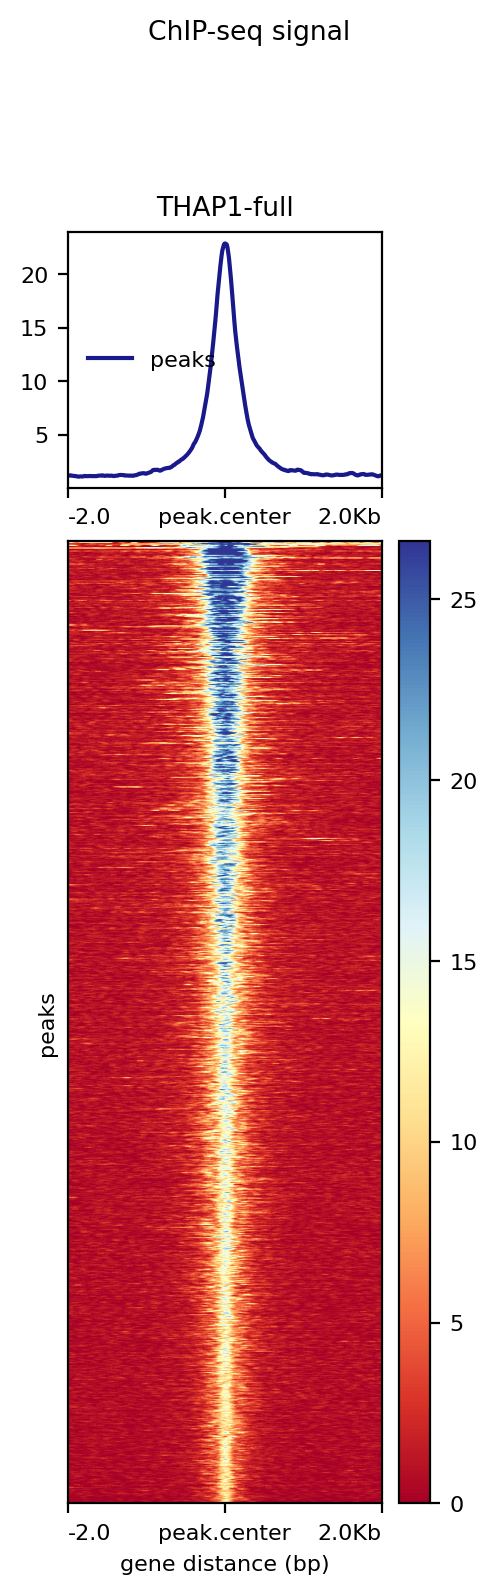


This plot shows the average ChIP-seq signal intensity (Y-axis) around the center of all peaks (X-axis).

* The heatmap suggests that THAP1 binds strongly at well-defined locations, as the signal is sharply focused at the peak centers. 
* The symmetric signal distribution around the peak center indicates that the binding activity is localized and does not spread extensively beyond the immediate region. 
* The broader signal distributions may indicate weaker or more diffuse binding events.

## 5. Moitf analysis

For the functional analysis, I proceed with the peaks that I obtained and see motifs enrichment.

Use the bed file as input to [i-cisTarget](https://gbiomed.kuleuven.be/apps/lcb/i-cisTarget/) for motif discovery.

In [19]:
mkdir -p motif_analysis 

In [26]:
ls

Control.bam                 THAP1.bam                    THAP1-full_summits.bed
Control.fastq               THAP1.fastq                  THAP1-full.tab.gz
Control.sorted.bam          THAP1-full.bw                THAP1-peaks.png
Control.sorted.bam.bai      THAP1-full_model.r           THAP1.sorted.bam
Epigenetics_ChIP_seq.ipynb  THAP1-full_peaks.bed         THAP1.sorted.bam.bai
motif_analysis              THAP1-full_peaks.narrowPeak
QC_results                  THAP1-full_peaks.xls


In [32]:
# Extract DNA sequences from a FASTA file based on genomic coordinates provided in a BED file.
bedtools getfasta \
    -fi /mnt/storage/data/resources/hg19/hg19.fa \
    -bed THAP1-full_peaks.bed \
    -fo motif_analysis/THAP1-full_peaks.fasta
ls *.fasta

WARNING. chromosome (chr17_gl000205_random) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr17_gl000205_random) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr17_gl000205_random) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr4_gl000193_random) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr7_gl000195_random) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr7_gl000195_random) was not found in the FASTA file. Skipping.
WARNING. chromosome (chr7_gl000195_random) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrUn_gl000211) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrUn_gl000212) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrUn_gl000214) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrUn_gl000219) was not found in the FASTA file. Skipping.
WARNING. chromosome (chrUn_gl000219) was not found in the FASTA file. Skipp

The sequence composition:
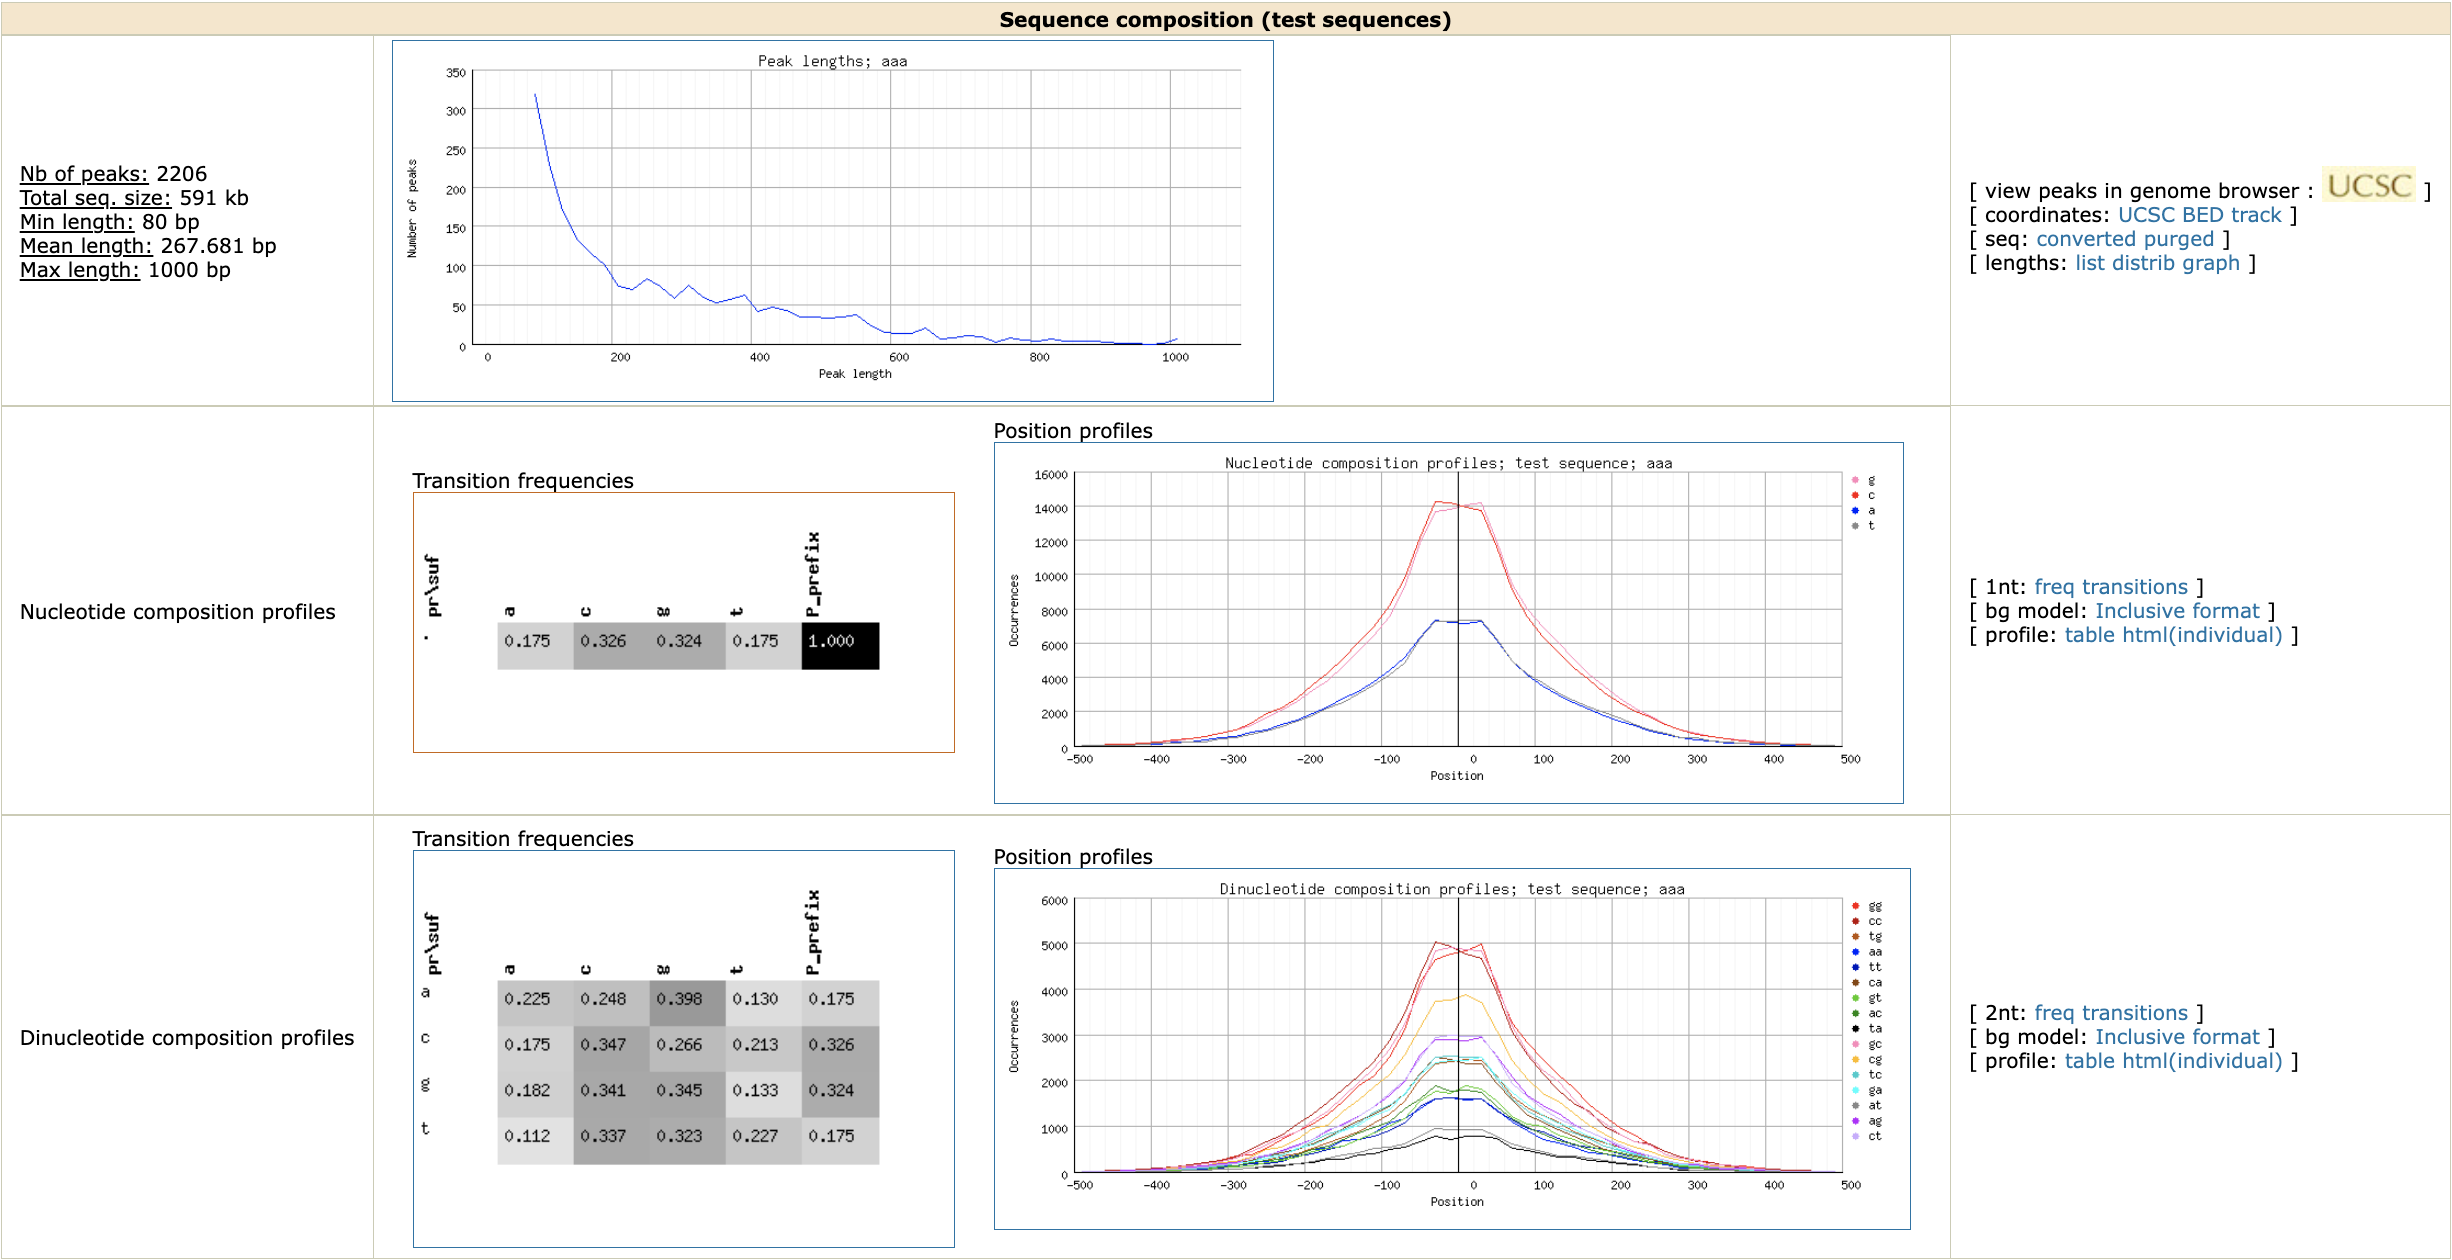
The motif discovery analysis revealed the potential biunding motifs of THAP1.  
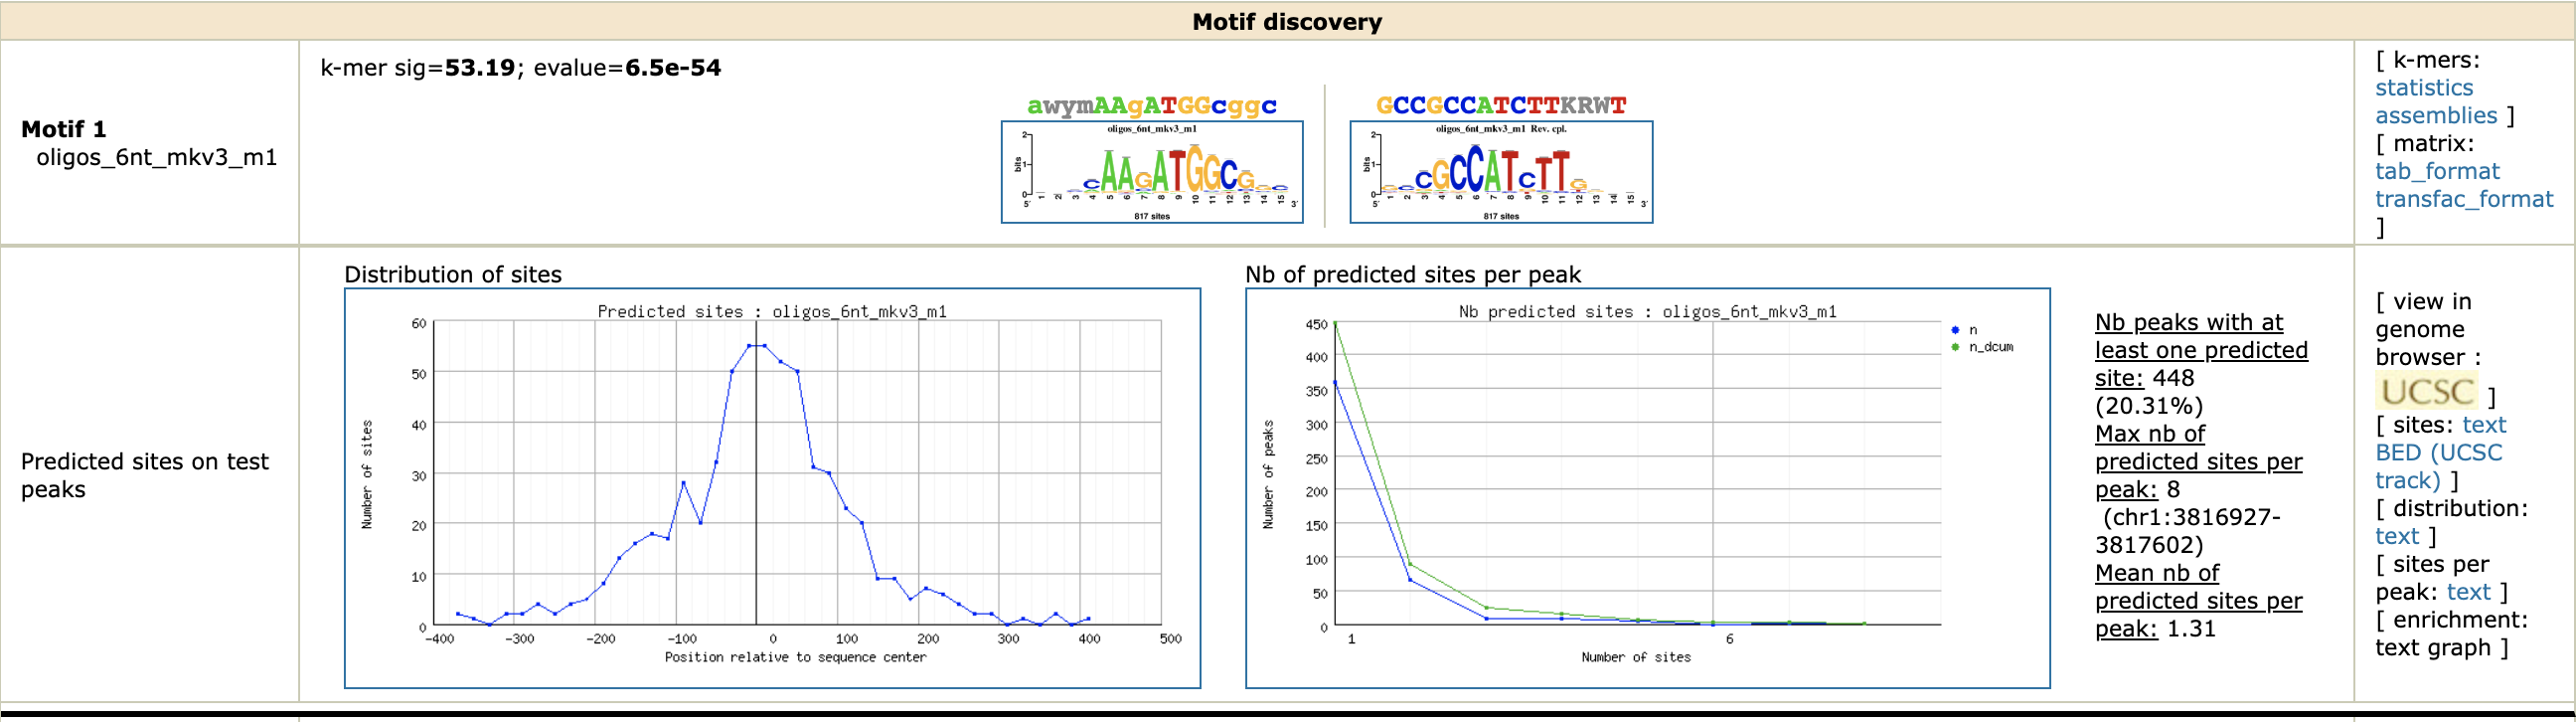
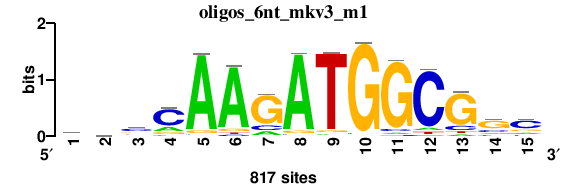
* Although significance very high,  Only 20% of the input peaks contain at least one instance of this motif.
* Most of the matches occur in the center of the peak, and most peaks have just a single motif instance.

The first motif found was the same as one of motifs (motif1) reported in the reference paper (Fig.1F).

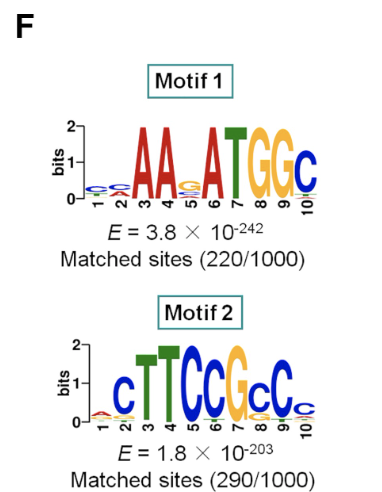

### Create a BED file with only the DIRECT peaks

448 peaks have a predicted site

In [34]:
cd motif_analysis

In [35]:
head -n 2 peak-motifs_oligos_6nt_mkv3_m1_sites.tab.txt

; matrix-scan  -quick -v 1 -seq_format fasta -i $RSAT/public_html/tmp/www-data/2024/12/26/peak-motifs.2024-12-26.171639_2024-12-26.171639_8V1aeh/data/sequences/peak-motifs_test_maxlen1000.fasta -matrix_format transfac -m $RSAT/public_html/tmp/www-data/2024/12/26/peak-motifs.2024-12-26.171639_2024-12-26.171639_8V1aeh/results/discovered_motifs/oligos_6nt_mkv3_m1/peak-motifs_oligos_6nt_mkv3_m1.tf -bg_format inclusive -bgfile $RSAT/public_html/tmp/www-data/2024/12/26/peak-motifs.2024-12-26.171639_2024-12-26.171639_8V1aeh/results/composition/peak-motifs_test_inclusive-1str-ovlp_2nt.txt -pseudo 1 -2str -decimals 1 -bg_pseudo 0.01 -n score -lth score 7.5 -origin center -offset 0 -return sites -o $RSAT/public_html/tmp/www-data/2024/12/26/peak-motifs.2024-12-26.171639_2024-12-26.171639_8V1aeh/results/discovered_motifs/oligos_6nt_mkv3_m1/peak-motifs_oligos_6nt_mkv3_m1_sites.tab
; Quick counting mode           


Filter out the non-relevant lines (starting with ; and #)

In [42]:
grep -v ";" peak-motifs_oligos_6nt_mkv3_m1_sites.tab.txt | head -n 2

#seq_id	ft_type	ft_name	strand	start	end	sequence	weight
chr1:1166887-1167714	site	oligos_6nt_mkv3_m1	R	49	63	AAGAAAGATGGCAGT	9.3
grep: write error: Broken pipe


In [37]:
grep -v ";" peak-motifs_oligos_6nt_mkv3_m1_sites.tab.txt | grep -v '#' | head -n 2

chr1:1166887-1167714	site	oligos_6nt_mkv3_m1	R	49	63	AAGAAAGATGGCAGT	9.3
chr1:1209142-1209261	site	oligos_6nt_mkv3_m1	D	3	17	CTCCAAGATGGCCGC	11.1
grep: write error: Broken pipe


Get the coordinate column and remove duplicates

In [46]:
cat peak-motifs_oligos_6nt_mkv3_m1_sites.tab.txt | grep -v ";" | grep -v "#" | awk '
    {   split($1, coords, "[:-]");
        chr=coords[1];
        start=coords[2] + $5; 
        end=coords[2] + $6; 
        peak_name="MACS_peak_" NR;
        print chr "\t" start "\t" end "\t" peak_name
    }' | sort -u > THAP1-allpeaks-with-motif-RSAT.bed

In [44]:
# Count the peaks with the motif
wc -l THAP1-allpeaks-with-motif-RSAT.bed

448 THAP1-allpeaks-with-motif-RSAT.bed


### PWM and track enrichment

Check whether the THAP1 ChIP-seq peaks we found are enriched for matches to known PSSMs (PWMs).\
To examine the peaks was tested on [i-cisTarget](https://gbiomed.kuleuven.be/apps/lcb/i-cisTarget/)

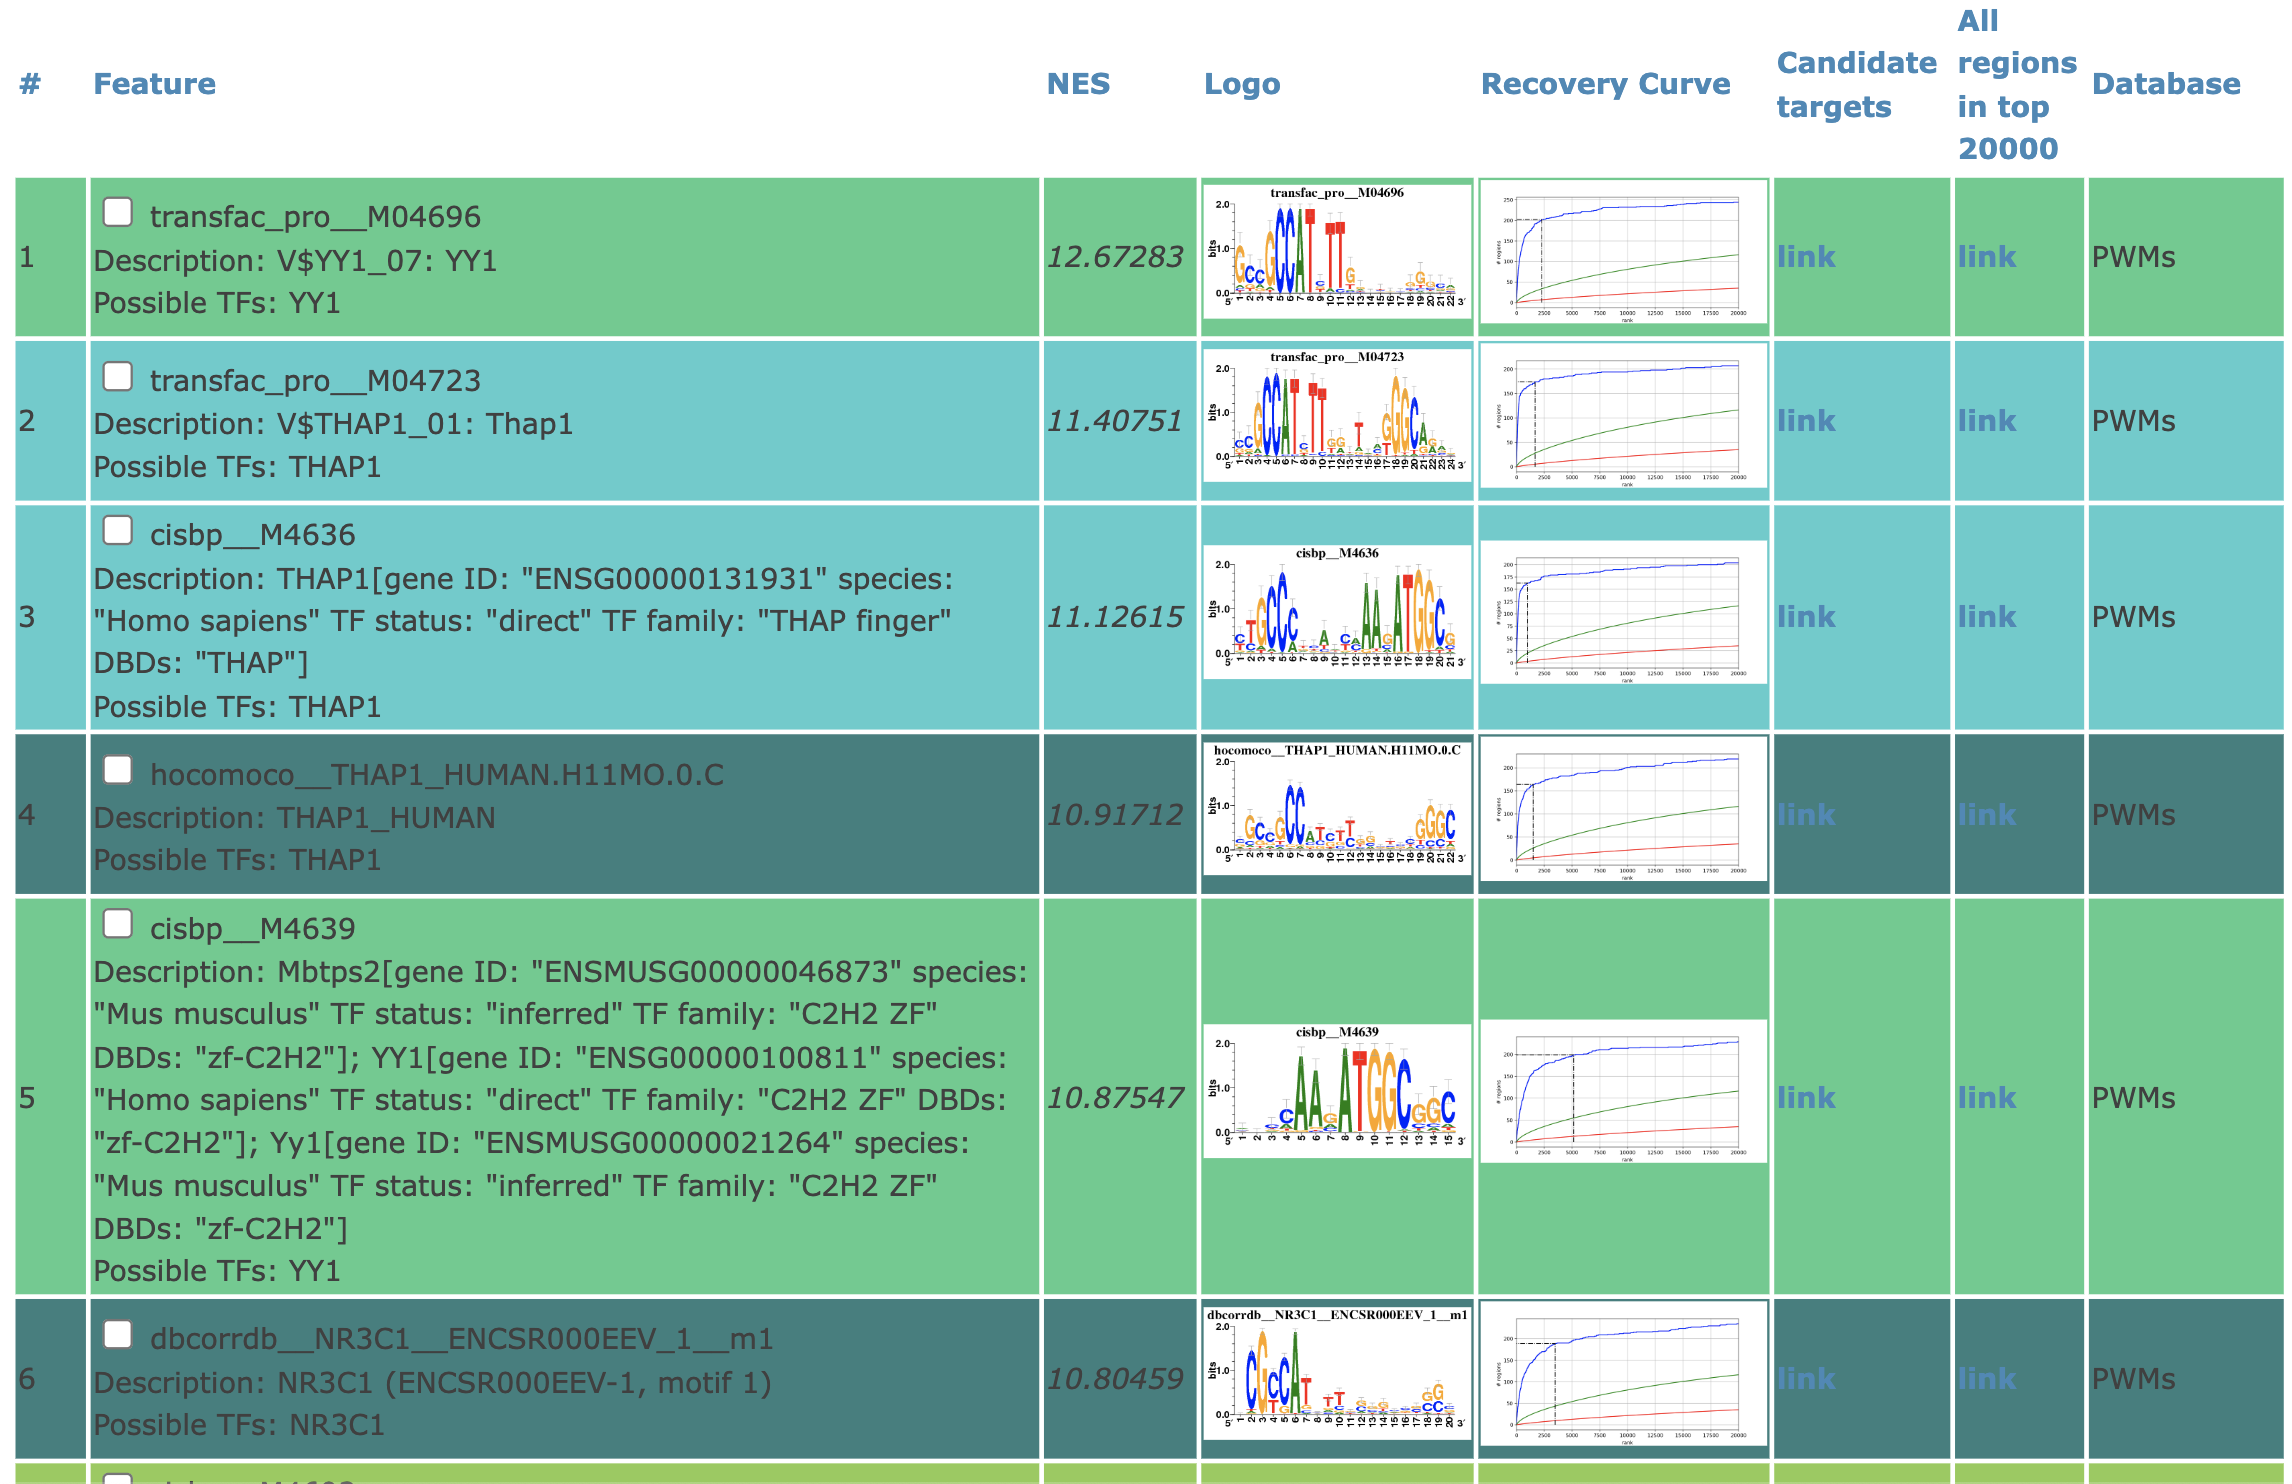

Although the top TF was not THAP1 (YY1 was detected first instead), multiple variations of THAP1 motif were found as shown in # 2,3,4


### Directly bound regions: Leading edge in i-cisTarget

In [47]:
head transfac_pro__M04723.targets.bed

track name=transfac_pro__M04723_candidate_targets description="" useScore=1
chr11	67249900	67250629	chr11-reg45718
chr20	18487686	18489455	chr20-reg14448
chr9	44244985	44245648	chr9-reg23912
chr9	123342256	123343196	chr9-reg64574
chrX	30905865	30908382	chrX-reg14067
chr1	90460118	90460816	chr1-reg80092
chr1	155210903	155211638	chr1-reg109994
chr1	161145850	161148275	chr1-reg115437
chr5	139943830	139945595	chr5-reg83587


In [48]:
wc -l transfac_pro__M04723.targets.bed

174 transfac_pro__M04723.targets.bed


## 6. Target gene analysis

[GREAT](http://great.stanford.edu/public/html/) was used to link peaks to genes. GREAT also determines Gene Ontology enrichment of the linked (target) genes.\
In a setting,a distance of 10kb is allowed between peak and gene following the setting used in the reference paper.

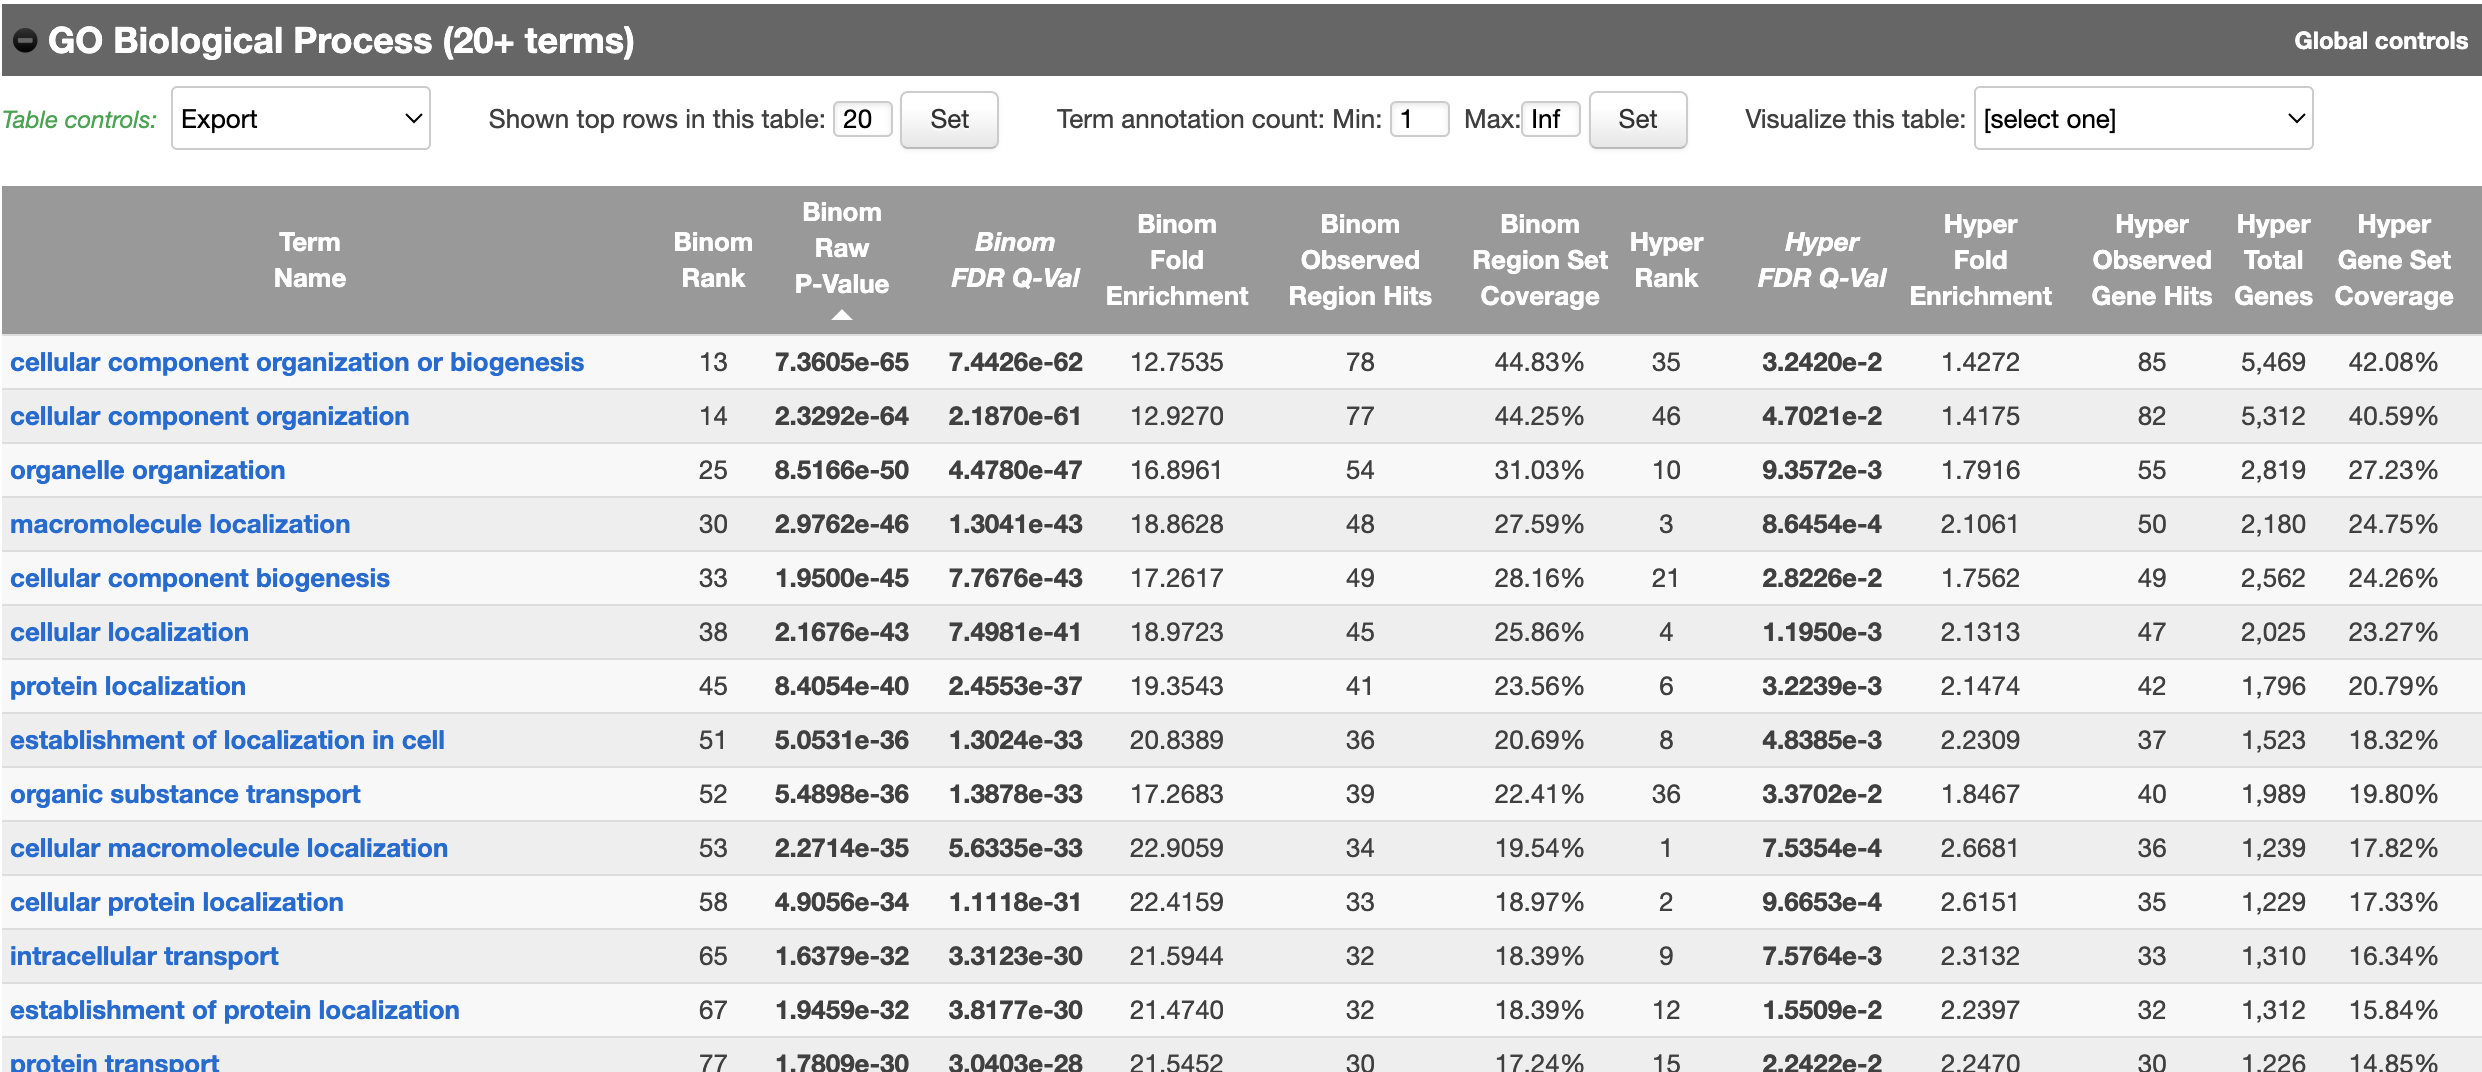

In the GO Biological process, functions related cellular components such as "Cellular component organization or biogenesis" and "Organelle organiazation" are top enriched in the regions.

Since the reference paper reported the "Gene ontology analysis showing the top affected pathways of common dysregulated genes of THAP1" are related to synaptic functions such as: ‘chemical synaptic transmission’ and ‘regulation of synaptic transmission, glutamatergic’, the gene ontology enrichment analysis showed different result.

In [50]:
pwd

/mnt/storage/r0965964/jupyternotebooks/epigenetics_assignment


In [51]:
mkdir gene_analysis

In [52]:
cd gene_analysis

In [53]:
head 20241227-public-4.0.4-Hrn4HV-hg19-all-region.txt

# GREAT version 4.0.4	Species assembly: hg19	Association rule: Basal+extension: 5000 bp upstream, 1000 bp downstream, 50000 bp max extension, curated regulatory domains included
chr11-reg45718	AIP (-247)
chr20-reg14448	SEC23B (+372)
chr9-reg23912	NONE
chr9-reg64574	CDK5RAP2 (-290)
chrX-reg14067	TAB3 (-21805)
chr1-reg80092	ZNF326 (-207)
chr1-reg109994	GBA (+3190), MTX1 (+32781)
chr1-reg115437	B4GALT3 (+212)
chr5-reg83587	APBB3 (-868), SLC35A4 (+237)


In [54]:
cat 20241227-public-4.0.4-Hrn4HV-hg19-all-region.txt | cut -f 1 | grep -v '#' | wc -l

175


We have 175 putative target genes. 

In [60]:
# Save these genes into a text file
cat 20241227-public-4.0.4-Hrn4HV-hg19-all-region.txt | cut -f 1 | grep -v '#' > THAP1-targets-GREAT.txt

### Comparison of predicted targets with functional associations to THAP1

See if some more of these genes are "related" to THAP1. Using [STRING](https://string-db.org/) I obtained a network of associated genes with THAP1.

THAP1 interacts with some proteins such as other THAP family proteins, Protein with chaperone functions (TOR1A), and Guanine nucleotide-binding protein (GNAL).

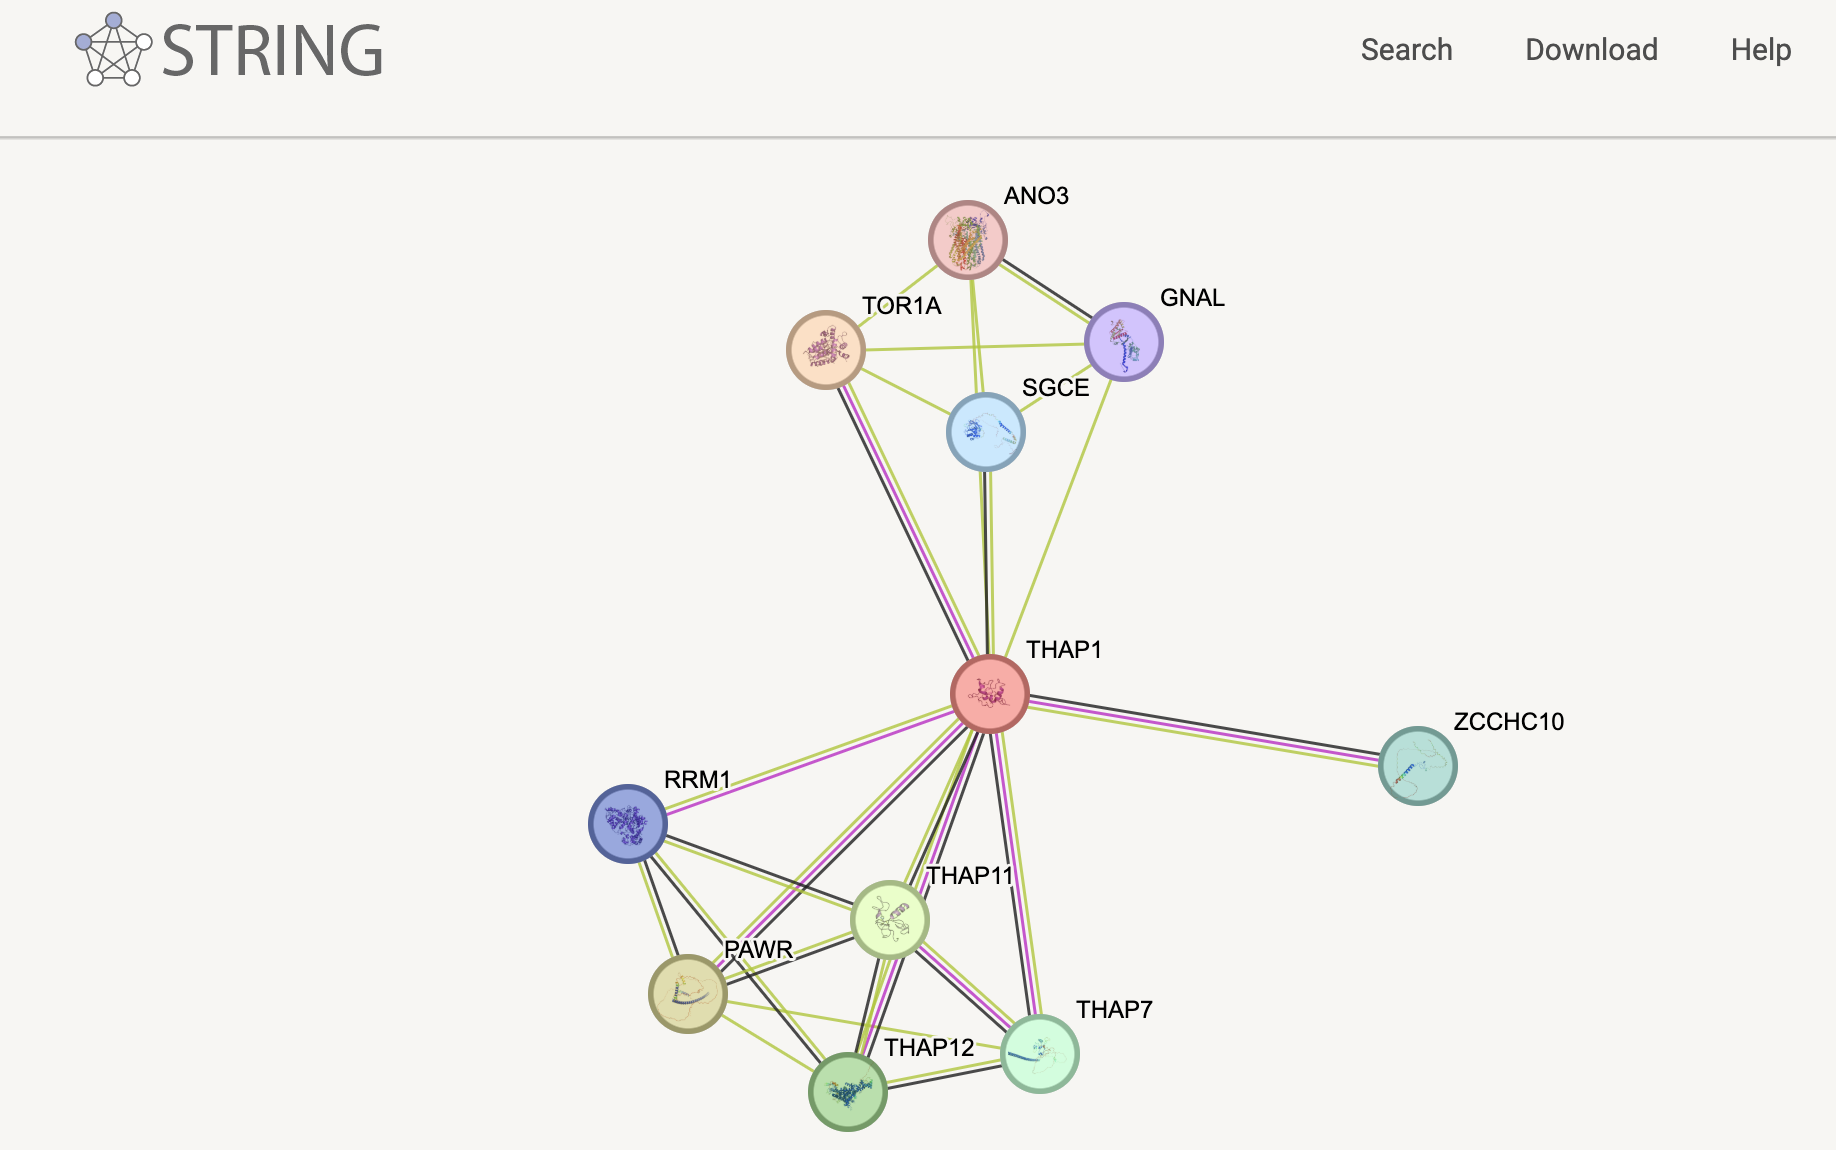

In [61]:
cat string_protein_annotations.tsv | cut -f1 | head

#node
ANO3
GNAL
PAWR
RRM1
SGCE
THAP1
THAP11
THAP12
THAP7


In [62]:
cat string_protein_annotations.tsv | cut -f 1 | grep -v '#' > THAP1-string-top.txt

In [64]:
list=`cat THAP1-string-top.txt`

In [65]:
for i in $list; do grep -w $i THAP1-targets-GREAT.txt; done

: 1

Comparison of predicted targets showed no overlap with network of associated genes THAP1

## Result & Discussion 

The motif discovery analysis successfully identified one of the motifs potentially bound by THAP1, consistent with motifs reported in the reference paper. This finding supports the reliability of the motif analysis and suggests that biologically relevant binding sites for THAP1 were captured.

However, discrepancies were observed in the target gene analysis. While the reference study reported significant pathway enrichment for processes such as ‘chemical synaptic transmission,’ ‘nervous system development,’ and ‘regulation of synaptic transmission, glutamatergic,’ this analysis showed enrichment in broader functional categories, including "Cellular component organization or biogenesis" and "Macromolecule localization." These differences suggest a potential divergence in pathway annotations or analytical workflows.

Notably, the reference study linked THAP1 to the regulation of SNCA expression and neuronal cell components. However, these findings were not entirely reproducible in this analysis. A possible explanation for this inconsistency is the indirect regulation of target genes. The reference study indicated that THAP1 regulates SNCA indirectly through intermediate pathways and other regulatory factors. Since the specific pathways involved in SNCA regulation were not fully elucidated in the reference study, identifying direct enrichment of the SNCA gene region or related factors poses a challenge.

In conclusion, while the motif discovery analysis aligns with the reference study and validates the biological relevance of THAP1 binding motifs, the discrepancies in pathway enrichment highlight potential limitations in this analysis. These inconsistencies may arise from indirect regulatory mechanisms, differences in experimental or computational approaches, and the lack of detailed pathway information for SNCA regulation in the reference study. 

Future studies should explore these pathways in greater depth, incorporating complementary datasets and standardized analytical methods to resolve these inconsistencies and better understand THAP1's role in regulating SNCA and neuronal processes.